In [1]:
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
from tqdm import tqdm
import sys
import pickle
import PyComplexHeatmap as pch
import scvi
import IPython
import pandas as pd
import scipy
import numpy as np
import itertools
import xarray as xr
sc.settings.figdir=os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/analysis/de_mts')
sc._settings.settings._vector_friendly=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis


import antipode

gs1=matplotlib.colors.ListedColormap(sc.pl.palettes.godsnot_102,name='godsnot_102')
try:
    matplotlib.colormaps.register(name='godsnot_102',cmap=gs1)
except:
    pass


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is not available


In [2]:
table_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/anno_tables/RNA'

In [3]:
batch_key='load_name'
species_key='organism'
donor_key='donor_id'
layer_key='UMIs'
leaf_key='Group'
MDE_KEY = "X_umap_species_integrated"
sex_key = "self_reported_sex"

In [4]:
adata = sc.read('/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/xspecies/Consensus_HMBA_basalganglia_AIT_pre-print.h5ad')

In [5]:
groups = pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/anno_tables/consensus_annotation_groups.tsv',header=None)[0]
adata.obs['Group'] = adata.obs['Group'].cat.reorder_categories(groups)

In [ ]:
adata.obs[species_key] = adata.obs[species_key].astype('category')
species_colors = {'Human':'#377eb8','Macaque':'#4daf4a','Marmoset':'#FF5F5D','Mouse':'#ffa300'}
adata.uns[f'{species_key}_colors'] = [species_colors[x] for x in adata.obs[species_key].cat.categories]

In [6]:
adata.obs[sex_key] = adata.obs[sex_key].astype(str)
adata.obs.loc[adata.obs[species_key]=='Marmoset',sex_key] = adata.obs.loc[adata.obs[species_key]=='Marmoset','donor_id']
adata.obs.loc[adata.obs[species_key]=='Marmoset',sex_key]
adata.obs['donor_id'].replace({'cjCroissant':'male','cjNutmeg':'male','cjJellybean':'female','cjRambo':'female'})
adata.obs[sex_key] = adata.obs[sex_key].replace({'cjCroissant':'male','cjNutmeg':'male','cjJellybean':'female','cjRambo':'female'}).astype('string')

/scratch/fast/4386645/ipykernel_2898813/292025461.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['donor_id'].replace({'cjCroissant':'male','cjNutmeg':'male','cjJellybean':'female','cjRambo':'female'})


In [7]:
adata.obs['sex'] = adata.obs[sex_key].astype(str).str.lower().astype('category')
sex_key = 'sex'

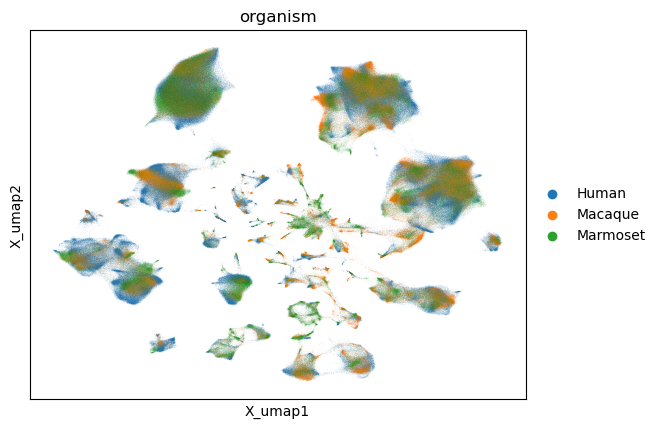

In [8]:
sc.pl.embedding(adata,color=species_key,basis='X_umap')

In [9]:
if not os.path.exists(os.path.join(table_dir, "species_group_means.netcdf")):
    # Get real means and xero proportions
    log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,species_key,leaf_key,layer=layer_key)
    real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
    real_means=real_means.loc[real_mean_levels[leaf_key],:]
    aggr_zeros=antipode.model_functions.group_aggr_anndata(adata,[species_key,leaf_key],layer=layer_key,agg_func=antipode.model_functions.prop_zeros,normalize=True)
    
    coords = {species_key:list(adata.obs[species_key].cat.categories),'Group':list(adata.obs['Group'].cat.categories),'var':list(adata.var.index.astype(str))}
    lrm = xr.DataArray(log_real_means,coords=coords)
    az = xr.DataArray(aggr_zeros[0],coords=coords)
    ads = xr.Dataset({'scalars':lrm,'proportions':az})
    ads.to_netcdf(os.path.join(table_dir, "species_group_means.netcdf"), engine="scipy")
else:
    ads = xr.open_dataset(os.path.join(table_dir, "species_group_means.netcdf"), engine="scipy")

In [10]:
if not os.path.exists(os.path.join(table_dir, "sex_group_means.netcdf")):
    log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,'sex',leaf_key,layer=layer_key)
    real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
    real_means=real_means.loc[real_mean_levels[leaf_key],:]
    aggr_zeros=antipode.model_functions.group_aggr_anndata(adata,['sex',leaf_key],layer=layer_key,agg_func=antipode.model_functions.prop_zeros,normalize=True)
    
    coords = {'sex':list(adata.obs['sex'].cat.categories),'Group':list(adata.obs['Group'].cat.categories),'var':list(adata.var.index.astype(str))}
    lrm = xr.DataArray(log_real_means,coords=coords)
    az = xr.DataArray(aggr_zeros[0],coords=coords)
    sads = xr.Dataset({'scalars':lrm,'proportions':az})
    sads.to_netcdf(os.path.join(table_dir, "sex_group_means.netcdf"), engine="scipy")
else:
    sads = xr.open_dataset(os.path.join(table_dir, "sex_group_means.netcdf"), engine="scipy")

In [11]:
# def _rgg_df_all_groups(ads, groupby, key="rank_genes_groups"):
#     try:
#         # works in newer Scanpy
#         return sc.get.rank_genes_groups_df(ads, None, key=key)
#     except TypeError:
#         # older Scanpy: must request one group at a time
#         frames = []
#         for g in list(ads.obs[groupby].cat.categories):
#             try:
#                 df_g = sc.get.rank_genes_groups_df(ads, g, key=key)
#                 frames.append(df_g)
#             except KeyError:
#                 continue
#         if not frames:
#             return pd.DataFrame(columns=["names","group","scores"])
#         return pd.concat(frames, ignore_index=True)

# def conserved_logreg_markers(
#     adata,
#     groupby="Group",
#     species_key="organism_name",
#     layer=None,
#     use_raw=False,
#     min_cells_per_group=5,
#     top_k=25,
#     normalize=False,
#     backed=False
# ):
#     if not pd.api.types.is_categorical_dtype(adata.obs[groupby]):
#         adata.obs[groupby] = adata.obs[groupby].astype("category")
#     group_levels = list(adata.obs[groupby].cat.categories)
#     species_levels = sorted(pd.Index(adata.obs[species_key]).unique())
#     genes = adata.var_names.to_list()
    
#     species_score_mats = {}
#     for sp in species_levels:
#         counts = adata.obs.loc[adata.obs[species_key] == sp][groupby].value_counts()
#         keep_groups = counts[counts >= min_cells_per_group].index.tolist()
#         if len(keep_groups) < 2:
#             species_score_mats[sp] = pd.DataFrame(np.nan, index=genes, columns=group_levels)
#             continue
#         ads = adata[(adata.obs[groupby].isin(keep_groups))&(adata.obs[species_key] == sp)]
#         if normalize:
#             sc.pp.normalize_total(ads,layer=layer)
#             sc.pp.log1p(ads,layer=layer)

#         sc.tl.rank_genes_groups(
#             ads,
#             groupby=groupby,
#             method="logreg",
#             n_genes=ads.n_vars,
#             layer=layer,
#             use_raw=use_raw
#         )

#         df = _rgg_df_all_groups(ads, groupby, key="rank_genes_groups")
#         if df.empty:
#             scmat = pd.DataFrame(np.nan, index=genes, columns=group_levels)
#         else:
#             scmat = (df.pivot(index="names", columns="group", values="scores")
#                        .reindex(index=genes, columns=group_levels))
#         species_score_mats[sp] = scmat

#     data = np.stack([species_score_mats[sp].to_numpy().T for sp in species_levels], axis=0)
#     da = xr.DataArray(
#         data,
#         coords={"species": species_levels, "group": group_levels, "gene": genes},
#         dims=("species", "group", "gene"),
#         name="logreg_score"
#     )

#     conserved_da = da.min(dim="species", skipna=True)
#     conserved_df = pd.DataFrame(
#         conserved_da.transpose("gene", "group").values,
#         index=genes,
#         columns=group_levels
#     )

#     top_genes = None
#     if top_k is not None:
#         top_genes = {
#             g: conserved_df[g].dropna().sort_values(ascending=False).head(top_k)
#             for g in group_levels
#         }

#     return da, conserved_df, top_genes

# # ---- usage ----
# # da_scores: xarray (species, group, gene) of logreg scores
# # conserved_df: DataFrame (gene × group) of per-gene min across species
# # top_genes: dict[group] -> top_k Series of conserved genes
# da_scores, conserved_df, top_genes = conserved_logreg_markers(
#     adata, groupby="Group", species_key="organism", layer='UMIs', use_raw=False, top_k=30,normalize=True,
# )
# da_scores.to_netcdf(os.path.join(sc.settings.figdir,'log_reg_markers.netcdf'))

# logreg_markers = [top_genes[x].index[:5] for x in da_scores.coords['group'].data]
# logreg_markers = list(itertools.chain(*logreg_markers))
# gene_order = logreg_markers
# antipode.plotting.pie_dotplot_xr(ads.sel(var=gene_order),row_dim='Group',col_dim='var',slice_dim=species_key,
#       scale_by='column', max_radius=0.4, figsize=(8, 6),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# # plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.pdf'), format='pdf')
# plt.show()

In [12]:
species_score_mats = {}
for sp in adata.obs['organism'].unique():
    sp = sp.lower()
    species_score_mats[sp] = pd.read_csv(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/analysis/de_genes_scanpy/logreg', f"{sp}_logreg_all_groups.csv"), 
                                         index_col=None).pivot(index='group', columns='names', values='scores').fillna(np.nan)
species_levels = list(species_score_mats.keys())
scores_array = xr.concat([xr.DataArray(species_score_mats[sp]) for sp in species_score_mats.keys()],dim='organism')
scores_array.coords['organism'] = list(species_score_mats.keys())
# to 111 orthologs
scores_array = scores_array.isel({'names':xr.ufuncs.isnan(scores_array).mean('group').sum('organism')<1.})
scores_array = scores_array.rename({'group':'Group','names':'var'}) #fix weidr names from table pivoting


In [13]:
# adata.uns['organism_name_color_dict'] = {"Human":"#377eb8", "Macaque":"#4daf4a", "Marmoset":"darkorchid", "Mouse":"darkorange"}
# adata.uns['organism_name_colors'] = [adata.uns['organism_name_color_dict'][x] for x in adata.obs[species_key].cat.categories]

In [14]:
# import os
import numpy as np
import pandas as pd
import xarray as xr
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

# preserve categorical orders if present
if pd.api.types.is_categorical_dtype(adata.obs[species_key]):
    species_levels = adata.obs[species_key].cat.categories.to_numpy()
else:
    species_levels = np.sort(adata.obs[species_key].unique())

if pd.api.types.is_categorical_dtype(adata.obs[leaf_key]):
    leaf_levels = adata.obs[leaf_key].cat.categories.to_numpy()
else:
    leaf_levels = np.sort(adata.obs[leaf_key].unique())

n_species = len(species_levels)
n_leaf = len(leaf_levels)
n_genes = adata.shape[1]
batch_cell_threshold = 20

species_pairs = [(i, j) for i in range(n_species) for j in range(i + 1, n_species)]
pair_to_idx   = {p: c for c, p in enumerate(species_pairs)}
contrast_labels = [f"{species_levels[i]}-{species_levels[j]}" for (i, j) in species_pairs]
sex_label = "sex:male-female"
contrast_labels_all = contrast_labels + [sex_label]
lfc_all  = np.full((len(contrast_labels_all), n_leaf, n_genes), np.nan, dtype=float)
padj_all = np.full((len(contrast_labels_all), n_leaf, n_genes), np.nan, dtype=float)
sex_cidx = len(contrast_labels_all) - 1

inference = DefaultInference(n_cpus=4)

def _std_sex(s):
    x = s.astype(str).str.strip().str.lower()
    x = x.replace({"m":"male","f":"female"})
    x = x.where(x.isin(["male","female"]), "unknown")
    return pd.Categorical(x, categories=["female","male","unknown"], ordered=True)

def _full_rank_ok(meta, use_species, use_sex):
    cols = ([species_key] if use_species else []) + (["sex_std"] if use_sex else [])
    if not cols:
        return False
    # ensure purely numeric design
    Z = meta[cols].astype("string")                         # avoid mixed/object dtypes
    X = pd.get_dummies(Z, drop_first=True, dtype=float)     # force float dummies
    if X.shape[1] == 0:
        return False
    X = np.c_[np.ones((X.shape[0], 1), dtype=float), X.to_numpy(dtype=float, copy=False)]
    r = np.linalg.matrix_rank(X)
    return r == X.shape[1]

def _sex_levels_present(meta):
    lvls = meta["sex_std"].unique().tolist()
    return ("male" in lvls) and ("female" in lvls)

def _not_confounded(meta):
    tab = pd.crosstab(meta[species_key], meta["sex_std"])
    tab = tab.reindex(columns=["female", "male"], fill_value=0)  # safe if a column is missing
    present = (tab > 0)
    return present.sum(axis=0).min() > 1 and present.sum(axis=1).min() > 1

out_nc = os.path.join(table_dir, "deseq2_bg.netcdf")
if not os.path.exists(out_nc):
    for k, lvl2 in enumerate(leaf_levels):
        print("Processing:", lvl2)
        adata_sub = adata[adata.obs[leaf_key] == lvl2].copy()

        layer = adata_sub.layers[layer_key]
        counts_mat = layer.todense() if hasattr(layer, "todense") else layer
        counts_df = pd.DataFrame(counts_mat.astype(int),
                                 index=adata_sub.obs_names,
                                 columns=adata_sub.var_names)

        metadata = adata_sub.obs.copy()
        metadata[species_key] = pd.Categorical(metadata[species_key],
                                               categories=species_levels, ordered=True)
        metadata[donor_key] = metadata[donor_key].astype(str)
        metadata["sex_std"] = _std_sex(metadata.get(sex_key, pd.Series(index=metadata.index, dtype=object)))

        batch_counts = metadata.groupby(donor_key).size()
        valid_batches = batch_counts[batch_counts >= batch_cell_threshold].index
        if len(valid_batches) == 0:
            print(f"  skip (no valid batches ≥{batch_cell_threshold})")
            continue

        metadata_pb = metadata[metadata[donor_key].isin(valid_batches)].copy()
        counts_df_pb = counts_df.loc[metadata_pb.index].groupby(metadata_pb[donor_key]).sum()
        metadata_pb = metadata_pb.groupby(donor_key).first()

        sp_counts = metadata_pb[species_key].value_counts()
        valid_species = sp_counts.index[sp_counts >= 1].tolist()
        if len(valid_species) < 2:
            print("  skip (need ≥2 species)")
            continue

        keep = metadata_pb[species_key].isin(valid_species)
        metadata_pb = metadata_pb.loc[keep].copy()
        counts_df_pb = counts_df_pb.loc[metadata_pb.index]
        metadata_pb[species_key] = pd.Categorical(metadata_pb[species_key],
                                                  categories=valid_species, ordered=True)
        if "sex" in metadata_pb:
            sex_raw = metadata_pb["sex"].astype(str).str.strip().str.lower()
        else:
            sex_raw = pd.Series(index=metadata_pb.index, dtype="string")
        
        sex_std = sex_raw.replace({"m": "male", "f": "female"})
        sex_std = sex_std.where(sex_std.isin(["male", "female"]), "unknown").astype("string")
        metadata_pb["sex_std"] = pd.Categorical(sex_std, categories=["female", "male", "unknown"], ordered=True)
        metadata_pb["sex_std"] = metadata_pb["sex_std"].cat.remove_unused_categories()

        use_sex = _sex_levels_present(metadata_pb) and _not_confounded(metadata_pb) and _full_rank_ok(metadata_pb, True, True)
        design = f"~ {species_key}" + (" + sex_std" if use_sex else "")
        # fit primary model for species (and sex if OK)
        try:
            dds = DeseqDataSet(counts=counts_df_pb, metadata=metadata_pb, design=design,
                               refit_cooks=True, inference=inference)
            dds.deseq2()
        except Exception as e:
            print(f"  model failed ({design}): {e}")
            continue

        present_to_global = {s: int(np.where(species_levels == s)[0][0]) for s in valid_species}

        # species contrasts
        for a in range(len(valid_species)):
            for b in range(a + 1, len(valid_species)):
                s_i, s_j = valid_species[a], valid_species[b]
                gi, gj = present_to_global[s_i], present_to_global[s_j]
                try:
                    ds = DeseqStats(dds, contrast=[species_key, s_i, s_j], inference=inference)
                    ds.summary()
                    res = ds.results_df.reindex(counts_df_pb.columns)
                    lfc, q = res["log2FoldChange"].to_numpy(), res["padj"].to_numpy()
                except Exception as e:
                    print(f"  contrast {s_i} vs {s_j} failed: {e}")
                    lfc = np.full(n_genes, np.nan); q = np.full(n_genes, np.nan)
                i, j = (gi, gj) if gi < gj else (gj, gi)
                cidx = pair_to_idx[(i, j)]
                sign = +1 if gi < gj else -1
                lfc_all[cidx, k, :]  = sign * lfc
                padj_all[cidx, k, :] = q

        # sex contrast
        if use_sex:
            try:
                ds_sex = DeseqStats(dds, contrast=["sex_std", "male", "female"], inference=inference)
                ds_sex.summary()
                res = ds_sex.results_df.reindex(counts_df_pb.columns)
                lfc_all[sex_cidx, k, :]  = res["log2FoldChange"].to_numpy()
                padj_all[sex_cidx, k, :] = res["padj"].to_numpy()
            except Exception as e:
                print(f"  sex contrast failed in primary model: {e}")
        else:
            meta_sf = metadata_pb.loc[metadata_pb["sex_std"].isin(["female","male"])].copy()
            if meta_sf.shape[0] >= 3 and _sex_levels_present(meta_sf) and _full_rank_ok(meta_sf, False, True):
                cdf_sf = counts_df_pb.loc[meta_sf.index]
                try:
                    dds2 = DeseqDataSet(counts=cdf_sf, metadata=meta_sf, design="~ sex_std",
                                        refit_cooks=True, inference=inference)
                    dds2.deseq2()
                    ds_sex = DeseqStats(dds2, contrast=["sex_std", "male", "female"], inference=inference)
                    ds_sex.summary()
                    res = ds_sex.results_df.reindex(cdf_sf.columns)
                    lfc_all[sex_cidx, k, :]  = res["log2FoldChange"].to_numpy()
                    padj_all[sex_cidx, k, :] = res["padj"].to_numpy()
                except Exception as e:
                    print(f"  sex-only model failed: {e}")
            else:
                print("  sex contrast not estimable (levels/replication/confounding)")

    deds = xr.Dataset(
        {"lfc": xr.DataArray(lfc_all,  dims=["contrast", leaf_key, "gene"],
                             coords={"contrast": contrast_labels_all, leaf_key: leaf_levels, "gene": adata.var_names}),
         "padj": xr.DataArray(padj_all, dims=["contrast", leaf_key, "gene"],
                              coords={"contrast": contrast_labels_all, leaf_key: leaf_levels, "gene": adata.var_names})}
    )
    deds.attrs["species_order"] = ",".join(map(str, species_levels))
    deds.attrs["group_order"]   = ",".join(map(str, leaf_levels))
    deds.attrs["sex_contrast"]  = sex_label
    deds.to_netcdf(out_nc, engine="scipy")


/scratch/fast/4386645/ipykernel_2898813/2867116722.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[species_key]):
/scratch/fast/4386645/ipykernel_2898813/2867116722.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[leaf_key]):


In [15]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

# preserve categorical orders if present
if pd.api.types.is_categorical_dtype(adata.obs[species_key]):
    species_levels = adata.obs[species_key].cat.categories.to_numpy()
else:
    species_levels = np.sort(adata.obs[species_key].unique())

if pd.api.types.is_categorical_dtype(adata.obs[leaf_key]):
    leaf_levels = adata.obs[leaf_key].cat.categories.to_numpy()
else:
    leaf_levels = np.sort(adata.obs[leaf_key].unique())

n_species = len(species_levels)
n_leaf = len(leaf_levels)
n_genes = adata.shape[1]
batch_cell_threshold = 20

inference = DefaultInference(n_cpus=4)

def _std_sex(s):
    x = s.astype(str).str.strip().str.lower()
    x = x.replace({"m": "male", "f": "female"})
    x = x.where(x.isin(["male", "female"]), "unknown")
    return pd.Categorical(x, categories=["female", "male", "unknown"], ordered=True)

def _full_rank_ok(meta):
    if "sex_std" not in meta.columns:
        return False
    Z = meta[["sex_std"]].astype("string")
    X = pd.get_dummies(Z, drop_first=True, dtype=float)
    if X.shape[1] == 0:
        return False
    X = np.c_[np.ones((X.shape[0], 1), dtype=float), X.to_numpy(dtype=float, copy=False)]
    r = np.linalg.matrix_rank(X)
    return r == X.shape[1]

def _sex_levels_present(meta):
    lvls = meta["sex_std"].cat.categories[meta["sex_std"].cat.categories.isin(meta["sex_std"].unique())]
    return ("male" in meta["sex_std"].unique()) and ("female" in meta["sex_std"].unique())

out_nc = os.path.join(table_dir, "deseq2_bg_sex_by_species.netcdf")

lfc_sex  = np.full((n_species, n_leaf, n_genes), np.nan, dtype=float)
padj_sex = np.full((n_species, n_leaf, n_genes), np.nan, dtype=float)
ok_mask  = np.zeros((n_species, n_leaf), dtype=bool)

if not os.path.exists(out_nc):
    for k, lvl2 in enumerate(leaf_levels):
        print("Processing:", lvl2)
        adata_sub = adata[adata.obs[leaf_key] == lvl2].copy()

        layer = adata_sub.layers[layer_key]
        counts_mat = layer.todense() if hasattr(layer, "todense") else layer
        counts_df = pd.DataFrame(
            counts_mat.astype(int),
            index=adata_sub.obs_names,
            columns=adata_sub.var_names
        )

        metadata = adata_sub.obs.copy()
        metadata[species_key] = pd.Categorical(metadata[species_key],
                                               categories=species_levels, ordered=True)
        metadata[donor_key] = metadata[donor_key].astype(str)
        metadata["sex_std"] = _std_sex(metadata.get(sex_key, pd.Series(index=metadata.index, dtype=object)))

        # collapse to donor-level with a minimum per-donor cell count
        batch_counts = metadata.groupby(donor_key).size()
        valid_batches = batch_counts[batch_counts >= batch_cell_threshold].index
        if len(valid_batches) == 0:
            print(f"  skip (no valid batches ≥{batch_cell_threshold})")
            continue

        metadata_pb   = metadata[metadata[donor_key].isin(valid_batches)].copy()
        counts_df_pb  = counts_df.loc[metadata_pb.index].groupby(metadata_pb[donor_key]).sum()
        metadata_pb   = metadata_pb.groupby(donor_key).first()

        # iterate species and run sex-only model per species
        for si, sp in enumerate(species_levels):
            meta_sp = metadata_pb.loc[metadata_pb[species_key] == sp].copy()
            if meta_sp.shape[0] < 2:
                continue

            # restrict to male/female; drop unknown
            meta_sp = meta_sp.loc[meta_sp["sex_std"].isin(["female", "male"])].copy()
            if meta_sp.shape[0] < 2 or not _sex_levels_present(meta_sp):
                continue

            cdf_sp = counts_df_pb.loc[meta_sp.index]
            # DESeq2 requires some replication; insist on >=1 donor per sex and >=3 donors total if possible
            sex_counts = meta_sp["sex_std"].value_counts()
            if (sex_counts.get("female", 0) < 1) or (sex_counts.get("male", 0) < 1) or (meta_sp.shape[0] < 3):
                continue

            meta_sp["sex_std"] = meta_sp["sex_std"].cat.remove_unused_categories()
            if not _full_rank_ok(meta_sp):
                continue

            try:
                dds = DeseqDataSet(counts=cdf_sp, metadata=meta_sp, design="~ sex_std",
                                   refit_cooks=True, inference=inference)
                dds.deseq2()
                ds = DeseqStats(dds, contrast=["sex_std", "male", "female"], inference=inference)
                ds.summary()
                res = ds.results_df.reindex(cdf_sp.columns)
                lfc_sex[si, k, :]  = res["log2FoldChange"].reindex(adata.var_names).to_numpy()
                padj_sex[si, k, :] = res["padj"].reindex(adata.var_names).to_numpy()
                ok_mask[si, k] = True
            except Exception as e:
                print(f"  {sp} sex model failed ({lvl2}): {e}")
                continue

    deds = xr.Dataset(
        {
            "lfc": xr.DataArray(
                lfc_sex, dims=["species", leaf_key, "gene"],
                coords={"species": species_levels, leaf_key: leaf_levels, "gene": adata.var_names}
            ),
            "padj": xr.DataArray(
                padj_sex, dims=["species", leaf_key, "gene"],
                coords={"species": species_levels, leaf_key: leaf_levels, "gene": adata.var_names}
            ),
            "ok": xr.DataArray(
                ok_mask, dims=["species", leaf_key],
                coords={"species": species_levels, leaf_key: leaf_levels}
            ),
        }
    )
    deds.attrs["species_order"] = ",".join(map(str, species_levels))
    deds.attrs["group_order"]   = ",".join(map(str, leaf_levels))
    deds.attrs["design"]        = "~ sex_std  (per species, per group)"
    deds.attrs["note"]          = f"donor-level aggregation; min {batch_cell_threshold} cells per donor"
    deds.to_netcdf(out_nc, engine="scipy")


/scratch/fast/4386645/ipykernel_2898813/2959625030.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[species_key]):
/scratch/fast/4386645/ipykernel_2898813/2959625030.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[leaf_key]):


In [16]:
# padj_array = deds['padj'].data
# lfc_array = deds['lfc'].data

In [17]:
def plot_up_down_counts(ds: xr.Dataset, alpha=0.05, lfc_thresh=0.0, save_dir=None,contrast_var="contrast"):
    groups = ds["Group"].values
    contrasts = ds[contrast_var].values

    for c in contrasts:
        padj = ds["padj"].sel({contrast_var:c})
        lfc  = ds["lfc"].sel({contrast_var:c})
        lfc_thresh = np.abs(lfc_thresh)
        
        sig   = padj < alpha
        up    = (sig & (lfc >  lfc_thresh)).sum(dim="gene").to_pandas()
        down  = (sig & (lfc < -lfc_thresh)).sum(dim="gene").to_pandas()

        x = np.arange(len(groups))
        w = 0.45
        fig, ax = plt.subplots(figsize=(max(10, len(groups)*0.25), 6))
        ax.bar(x - w/2, up.reindex(groups).fillna(0).astype(int),  width=w, label=f"Up (>{lfc_thresh})")
        ax.bar(x + w/2, down.reindex(groups).fillna(0).astype(int), width=w, label=f"Down (<{-lfc_thresh})")

        ax.set_xticks(x)
        ax.set_xticklabels(groups, rotation=90)
        ax.set_ylabel("# genes")
        ax.set_title(f"{c} (padj < {alpha})")
        ax.legend(frameon=False)
        fig.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            fig.savefig(os.path.join(save_dir, f"updown_{str(c).replace(' ','_')}.pdf"), bbox_inches="tight")
        plt.show()



In [18]:
deds = xr.open_dataset(os.path.join(table_dir, "deseq2_bg_sex_by_species.netcdf"))

In [19]:
ads = ads.sel({leaf_key:adata.obs[leaf_key].cat.categories})
sads = sads.sel({leaf_key:adata.obs[leaf_key].cat.categories})
deds = deds.sel({leaf_key:adata.obs[leaf_key].cat.categories})

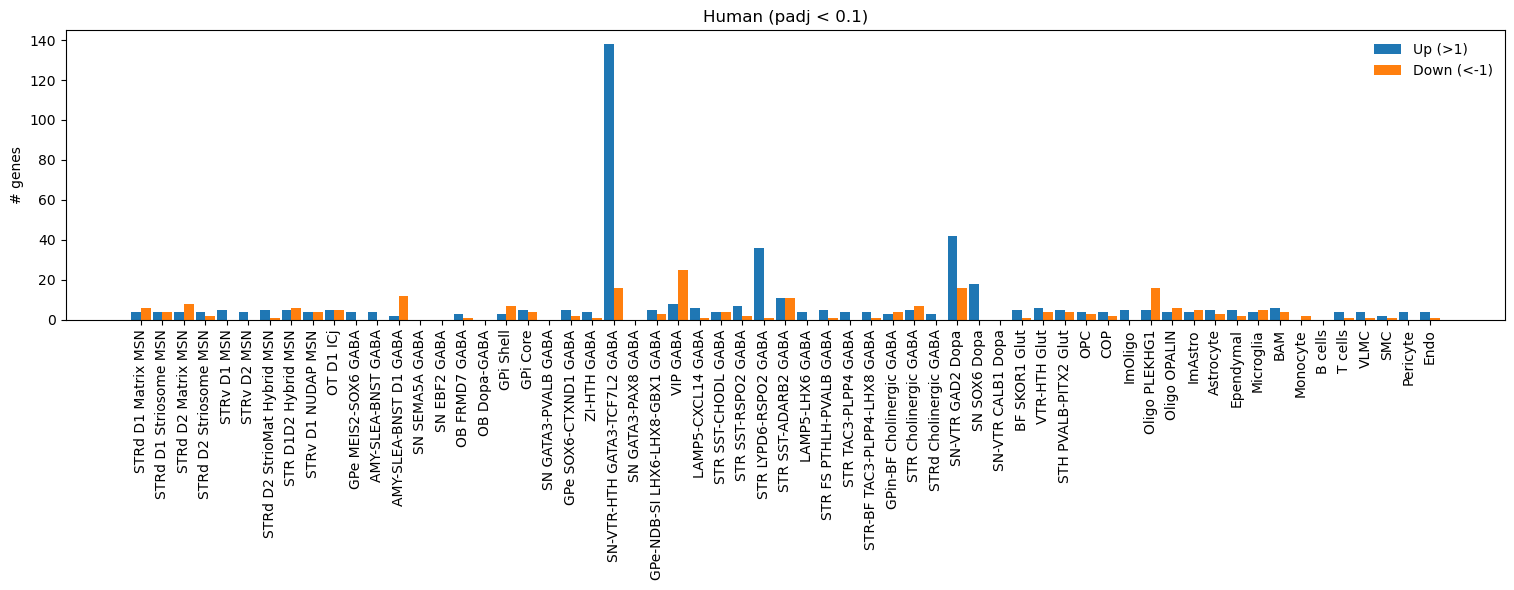

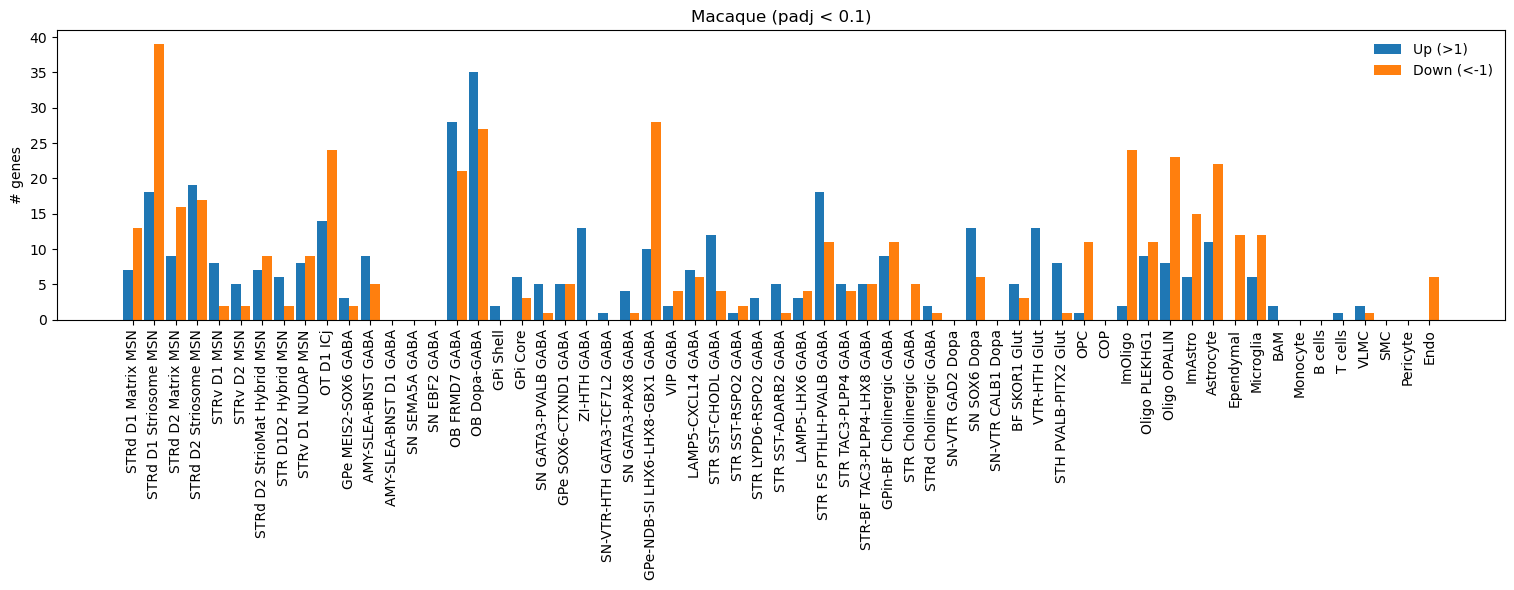

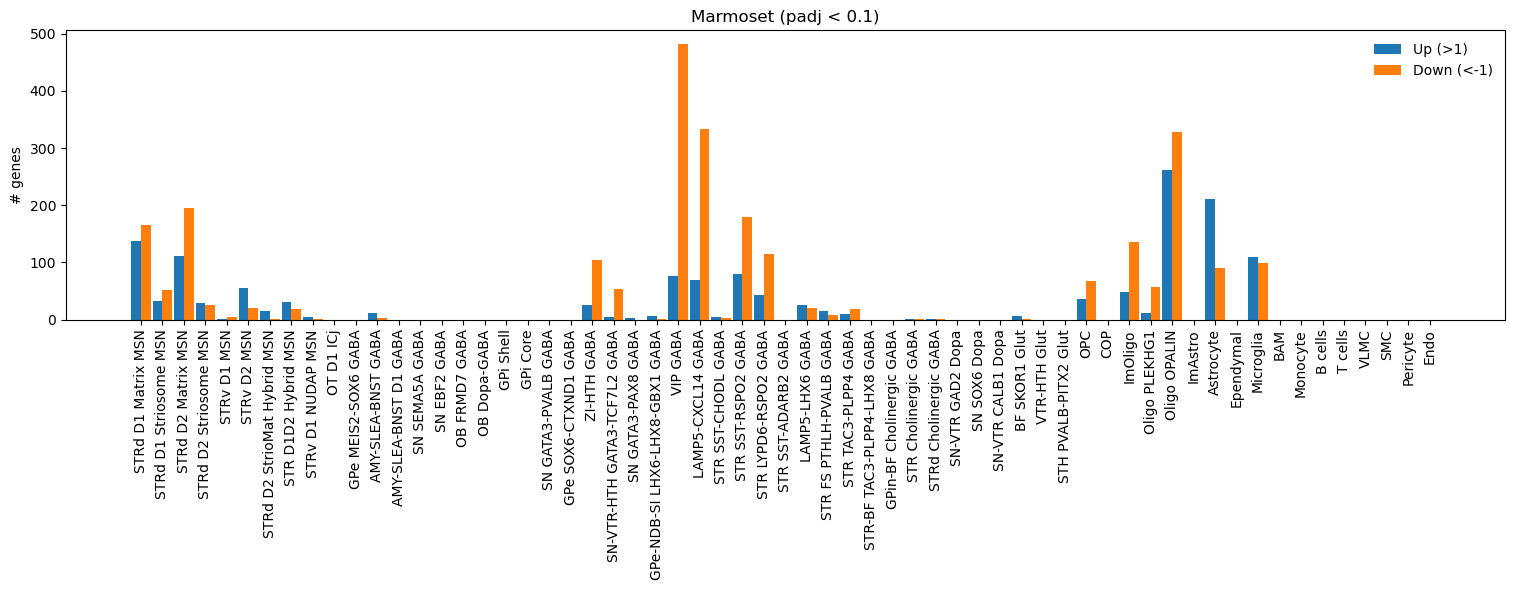

In [20]:
plot_up_down_counts(deds,lfc_thresh=1,alpha=0.1,save_dir=sc.settings.figdir,contrast_var='species')

In [21]:
deds = xr.open_dataset(os.path.join(table_dir, "deseq2_bg.netcdf"))

In [22]:
ads = ads.sel({leaf_key:adata.obs[leaf_key].cat.categories})
sads = sads.sel({leaf_key:adata.obs[leaf_key].cat.categories})
deds = deds.sel({leaf_key:adata.obs[leaf_key].cat.categories})

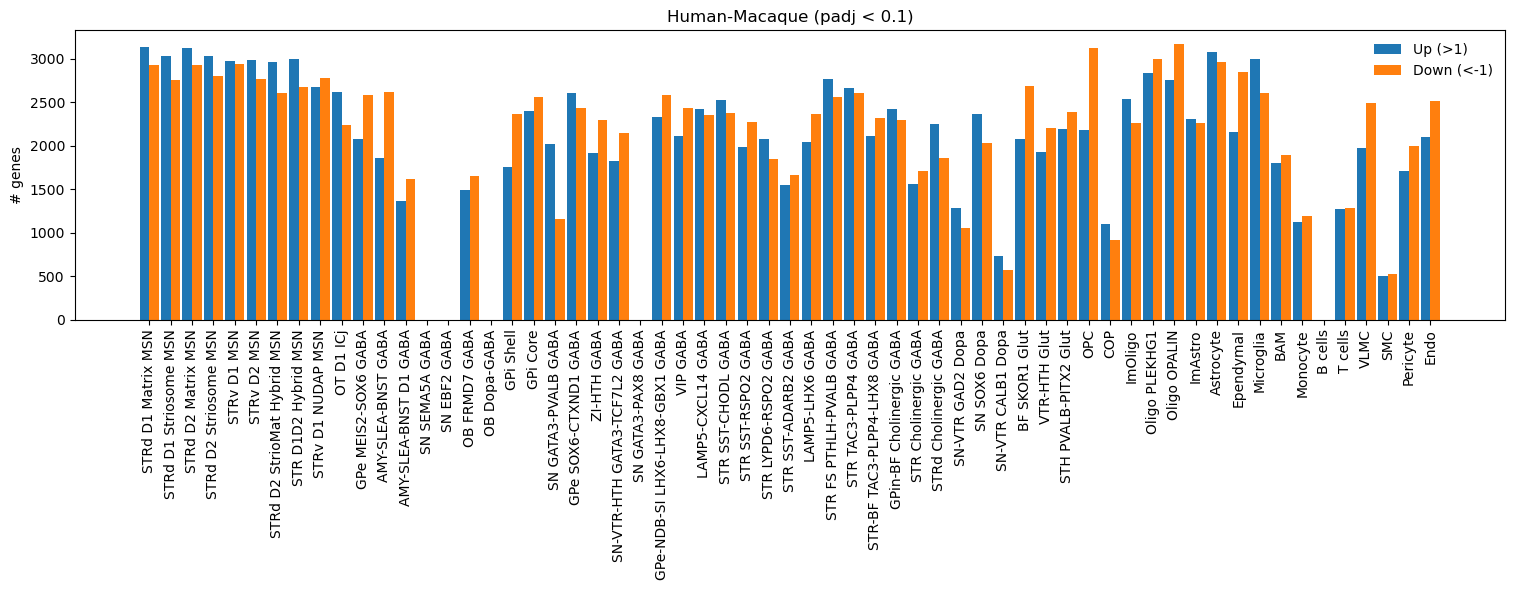

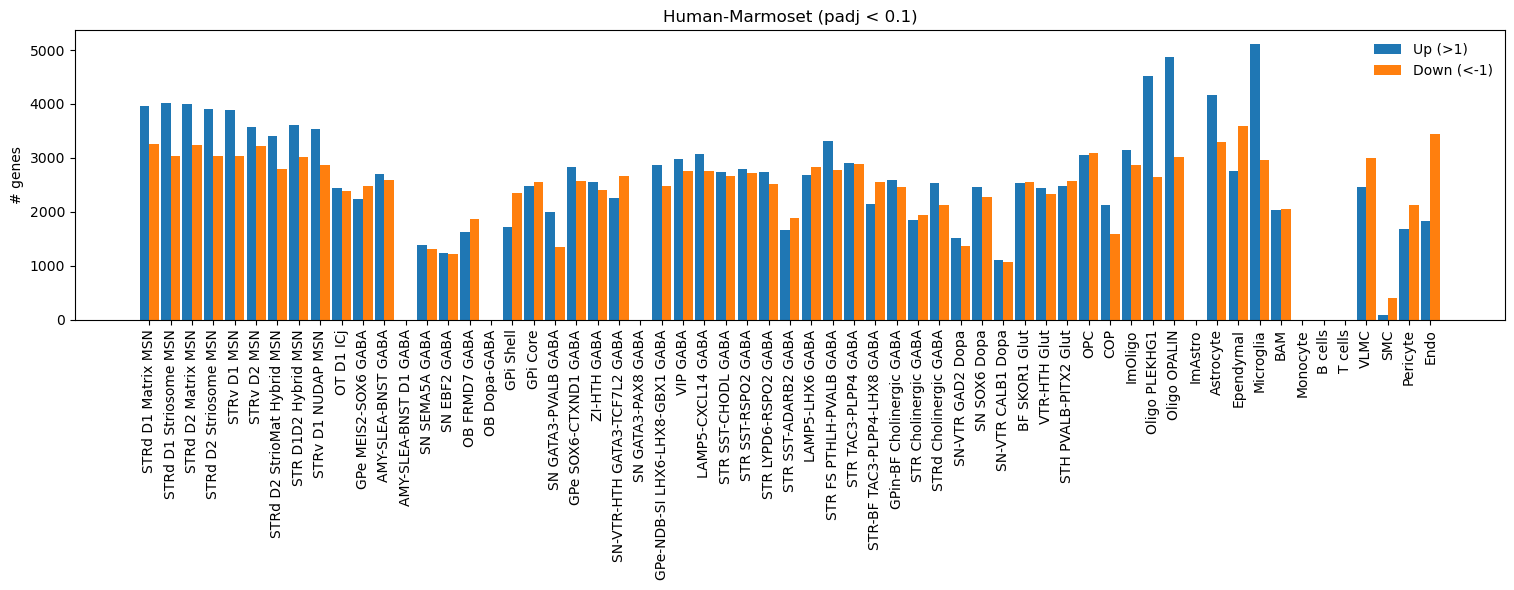

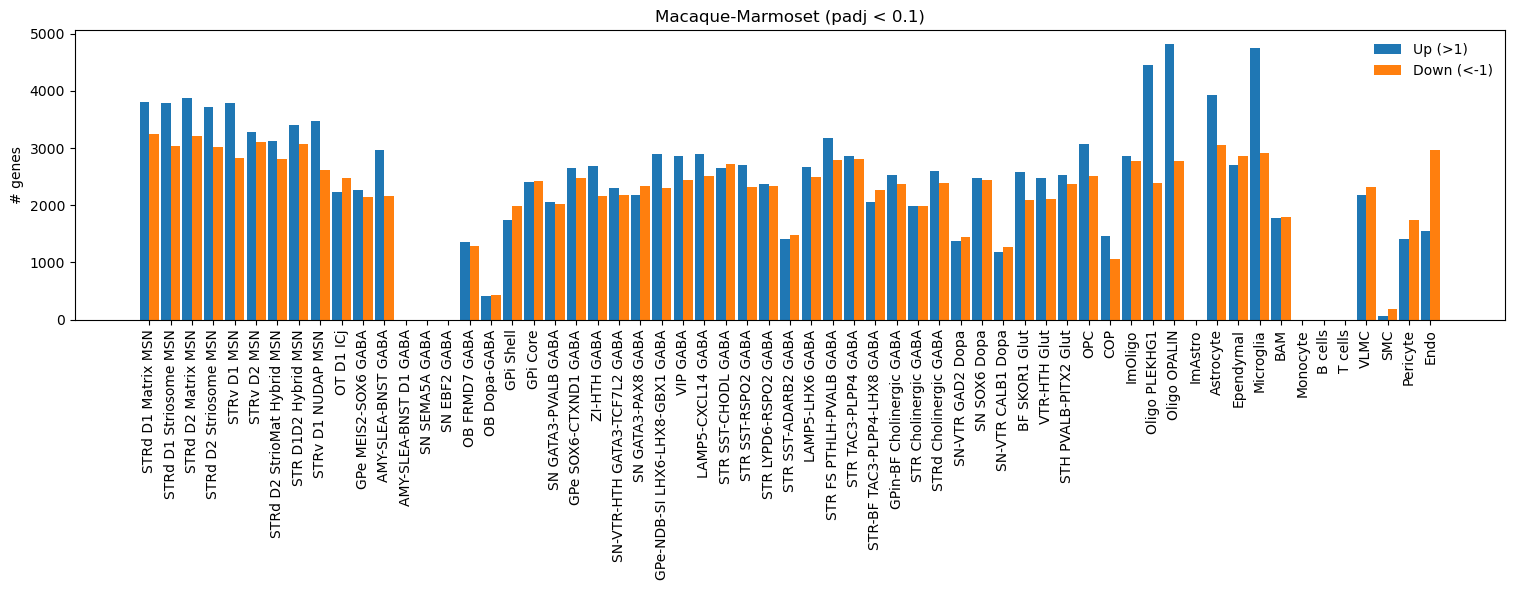

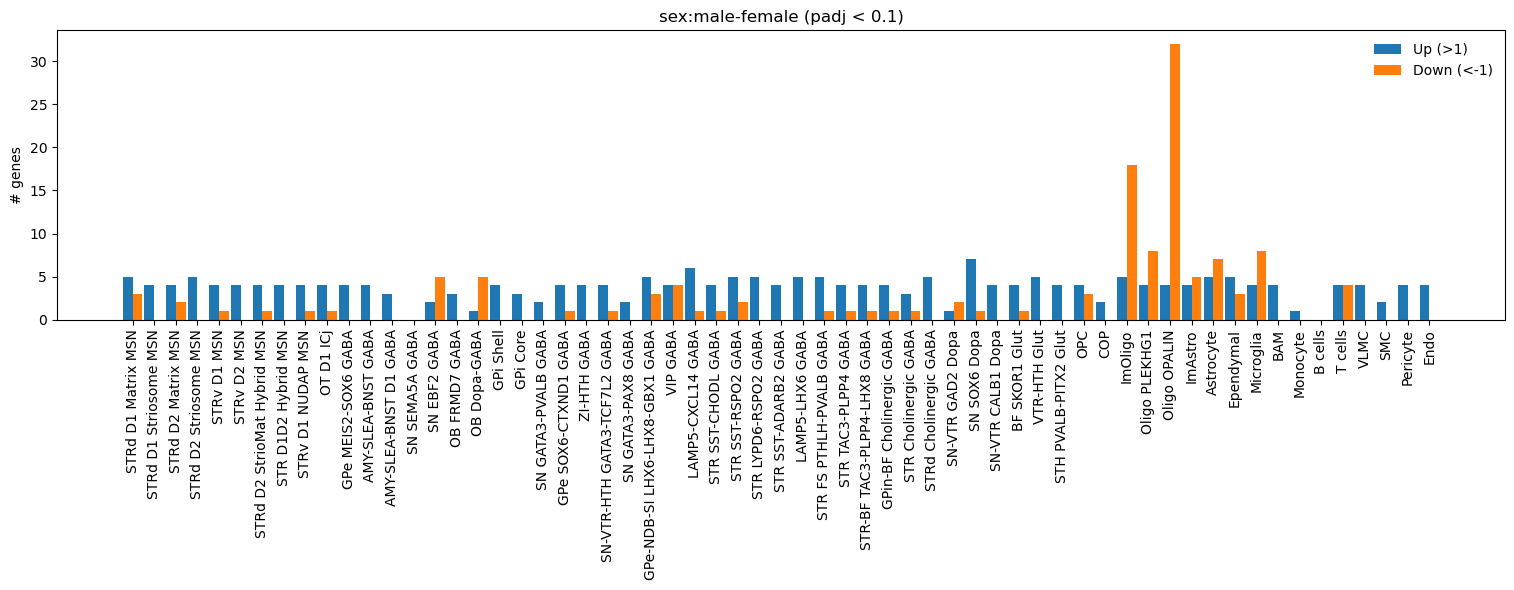

In [27]:
plot_up_down_counts(deds,lfc_thresh=1,alpha=0.1,save_dir=sc.settings.figdir)

In [33]:
lfc_thresh = 1.
alpha = 0.1
c= 'sex:male-female'
padj = deds["padj"].sel(contrast=c)
lfc  = deds["lfc"].sel(contrast=c)
genes = deds.coords['gene'].data

sig   = padj < alpha
up    = (sig & (lfc >  lfc_thresh))
down  = (sig & (lfc < -lfc_thresh))

up_genes = {}
down_genes = {}

for g in deds.coords['Group'].data:
    up_genes[g] = genes[up.sel(Group=g)]
    down_genes[g] = genes[down.sel(Group=g)]

In [34]:
import itertools
print(set(list(itertools.chain(*up_genes.values()))))
print(set(list(itertools.chain(*down_genes.values()))))

{'PLCXD1', 'SRY', 'NAV3', 'LRRTM4', 'NCALD', 'CD163', 'VCAM1', 'PRSS12', 'C3', 'FAAH2', 'MEIS2', 'PKHD1L1', 'GABRA6', 'FRY', 'KCTD8', 'RYR3', 'DDX3Y', 'EIF1AY', 'KDM5D', 'CPXM2', 'SOX6', 'PRDM8', 'STAT4', 'CRHR2', 'ZFY', 'GTPBP6'}
{'HRH1', 'TCTEX1D4', 'PDE10A', 'PTPRR', 'BIRC5', 'CLEC2B', 'SRRM4', 'DYSF', 'FRMPD2', 'XIRP2', 'ANXA10', 'LGALS3', 'SYNPR', 'FRMD1', 'EPHA3', 'KLHL1', 'LGR6', 'ITGB6', 'CXCR6', 'SULT1C4', 'EBF2', 'MYBPC1', 'CRHBP', 'PDE1A', 'KDM5C', 'EXT1', 'EFNA5', 'RYR2', 'KCND3', 'TRPC3', 'ST3GAL1', 'KANK4', 'ZC3HAV1', 'FAP', 'RAB37', 'GMPR', 'RGS3', 'COLEC12', 'MISP', 'HEYL', 'NRXN1', 'ZRSR2', 'CNBD1', 'SKOR2', 'BVES', 'RARRES2', 'CDC20B', 'STAC', 'BIRC3', 'ABCB1', 'EXOC3L1', 'LUZP2', 'SORCS3', 'ROBO2', 'C3H5orf47', 'UBL5', 'TRPC7', 'CASQ2', 'HSPA8', 'ALDH1A1', 'ZBBX', 'CDH20', 'ARHGAP10', 'USH1C', 'LHFPL6', 'HS3ST2', 'AGBL1', 'GJA3', 'GPNMB', 'CETP', 'C1H1orf53', 'ST6GALNAC5', 'DNAJB1', 'KCNJ6', 'CHRNA1', 'C2CD4B', 'PDE7B', 'LHX9', 'FAM160A1', 'HRH2', 'SIGLEC1', 'FSTL5',

In [35]:
sads

<xarray.Dataset> Size: 33MB
Dimensions:      (var: 16630, Group: 61, sex: 2)
Coordinates:
  * var          (var) object 133kB 'GMEB2' 'MRPS18B' ... 'UCKL1' 'CCDC103'
  * Group        (Group) object 488B 'STRd D1 Matrix MSN' ... 'Endo'
  * sex          (sex) object 16B 'female' 'male'
Data variables:
    scalars      (sex, Group, var) float64 16MB ...
    proportions  (sex, Group, var) float64 16MB ...

In [36]:
import collections
up_counts = collections.Counter(list(itertools.chain(*up_genes.values())))
print(up_counts)
filtered = {k: [g for g in v if up_counts[g] < 5] for k, v in up_genes.items()}
{k: v for k, v in filtered.items() if len(v) > 0}

Counter({'ZFY': 56, 'KDM5D': 55, 'DDX3Y': 51, 'EIF1AY': 45, 'SRY': 2, 'VCAM1': 1, 'CPXM2': 1, 'RYR3': 1, 'C3': 1, 'CRHR2': 1, 'GABRA6': 1, 'PRSS12': 1, 'MEIS2': 1, 'NCALD': 1, 'GTPBP6': 1, 'CD163': 1, 'SOX6': 1, 'PKHD1L1': 1, 'KCTD8': 1, 'PLCXD1': 1, 'FAAH2': 1, 'STAT4': 1, 'LRRTM4': 1, 'PRDM8': 1, 'FRY': 1, 'NAV3': 1})


{'STRd D1 Matrix MSN': ['VCAM1'],
 'STRd D2 Striosome MSN': ['CPXM2'],
 'OB Dopa-GABA': ['RYR3'],
 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA': ['C3'],
 'LAMP5-CXCL14 GABA': ['CRHR2', 'GABRA6'],
 'STR SST-RSPO2 GABA': ['PRSS12'],
 'STR LYPD6-RSPO2 GABA': ['MEIS2'],
 'STR SST-ADARB2 GABA': ['NCALD'],
 'LAMP5-LHX6 GABA': ['GTPBP6'],
 'STR FS PTHLH-PVALB GABA': ['CD163'],
 'STRd Cholinergic GABA': ['SOX6'],
 'SN SOX6 Dopa': ['PKHD1L1', 'KCTD8', 'PLCXD1'],
 'SN-VTR CALB1 Dopa': ['FAAH2', 'STAT4', 'LRRTM4'],
 'VTR-HTH Glut': ['PRDM8'],
 'ImOligo': ['FRY'],
 'Astrocyte': ['SRY'],
 'Ependymal': ['SRY'],
 'Monocyte': ['NAV3']}

In [37]:
down_counts = collections.Counter(list(itertools.chain(*down_genes.values())))
print(down_counts)
filtered = {k: [g for g in v if up_counts[g] < 5] for k, v in down_genes.items()}
{k: v for k, v in filtered.items() if len(v) > 0}


Counter({'ANXA10': 3, 'ADCY2': 3, 'PNPLA4': 2, 'ETV5': 2, 'ZC3HAV1': 2, 'FAM160A1': 2, 'GPNMB': 2, 'JPH1': 2, 'RYR2': 2, 'ROBO2': 2, 'CNBD1': 2, 'TBXT': 1, 'LGALS3': 1, 'FAP': 1, 'FRMD1': 1, 'GJA3': 1, 'SGCZ': 1, 'EXT1': 1, 'NELL1': 1, 'FREM1': 1, 'AGBL1': 1, 'CDH20': 1, 'COL2A1': 1, 'LHFPL6': 1, 'MYBPC1': 1, 'ABCB1': 1, 'SKOR2': 1, 'TRPC3': 1, 'DNAH8': 1, 'STAC': 1, 'C3H5orf47': 1, 'ESRP1': 1, 'TRPC7': 1, 'BVES': 1, 'PGR': 1, 'DPP4': 1, 'ST3GAL1': 1, 'BIRC5': 1, 'PDE10A': 1, 'LUZP2': 1, 'HRH2': 1, 'LHX9': 1, 'TWIST2': 1, 'ST6GALNAC5': 1, 'SIGLEC1': 1, 'SYNPR': 1, 'KIAA1217': 1, 'ARHGAP10': 1, 'SRRM4': 1, 'PTPRR': 1, 'COLEC12': 1, 'PDE7B': 1, 'EFNA5': 1, 'RARRES2': 1, 'USH1C': 1, 'KCNJ6': 1, 'CRHBP': 1, 'CLEC2B': 1, 'DNAH7': 1, 'C1H1orf53': 1, 'FRMPD2': 1, 'EHF': 1, 'CETP': 1, 'EPHA3': 1, 'SH2D4A': 1, 'HRH1': 1, 'MMP16': 1, 'KLHL1': 1, 'NRXN1': 1, 'EBF2': 1, 'ALDH1A1': 1, 'MISP': 1, 'KANK4': 1, 'MEIS3': 1, 'CHRNA1': 1, 'ICA1': 1, 'SULT1C4': 1, 'SLC26A5': 1, 'FSTL5': 1, 'HEYL': 1, 'LGR6

{'STRd D1 Matrix MSN': ['TBXT', 'LGALS3', 'ANXA10'],
 'STRd D2 Matrix MSN': ['ANXA10', 'FAP'],
 'STRv D1 MSN': ['FRMD1'],
 'STRd D2 StrioMat Hybrid MSN': ['PNPLA4'],
 'STRv D1 NUDAP MSN': ['GJA3'],
 'OT D1 ICj': ['ETV5'],
 'SN EBF2 GABA': ['SGCZ', 'EXT1', 'NELL1', 'FREM1', 'AGBL1'],
 'OB Dopa-GABA': ['CDH20', 'COL2A1', 'LHFPL6', 'MYBPC1', 'ABCB1'],
 'GPe SOX6-CTXND1 GABA': ['PNPLA4'],
 'SN-VTR-HTH GATA3-TCF7L2 GABA': ['SKOR2'],
 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA': ['ZC3HAV1', 'ETV5', 'FAM160A1'],
 'VIP GABA': ['TRPC3', 'DNAH8', 'FAM160A1', 'STAC'],
 'LAMP5-CXCL14 GABA': ['C3H5orf47'],
 'STR SST-CHODL GABA': ['ESRP1'],
 'STR SST-RSPO2 GABA': ['TRPC7', 'BVES'],
 'STR FS PTHLH-PVALB GABA': ['PGR'],
 'STR TAC3-PLPP4 GABA': ['ANXA10'],
 'STR-BF TAC3-PLPP4-LHX8 GABA': ['DPP4'],
 'GPin-BF Cholinergic GABA': ['ST3GAL1'],
 'STR Cholinergic GABA': ['BIRC5'],
 'SN-VTR GAD2 Dopa': ['PDE10A', 'LUZP2'],
 'SN SOX6 Dopa': ['HRH2'],
 'BF SKOR1 Glut': ['ZC3HAV1'],
 'OPC': ['LHX9', 'TWIST2', 'ST6GALNAC5'],

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


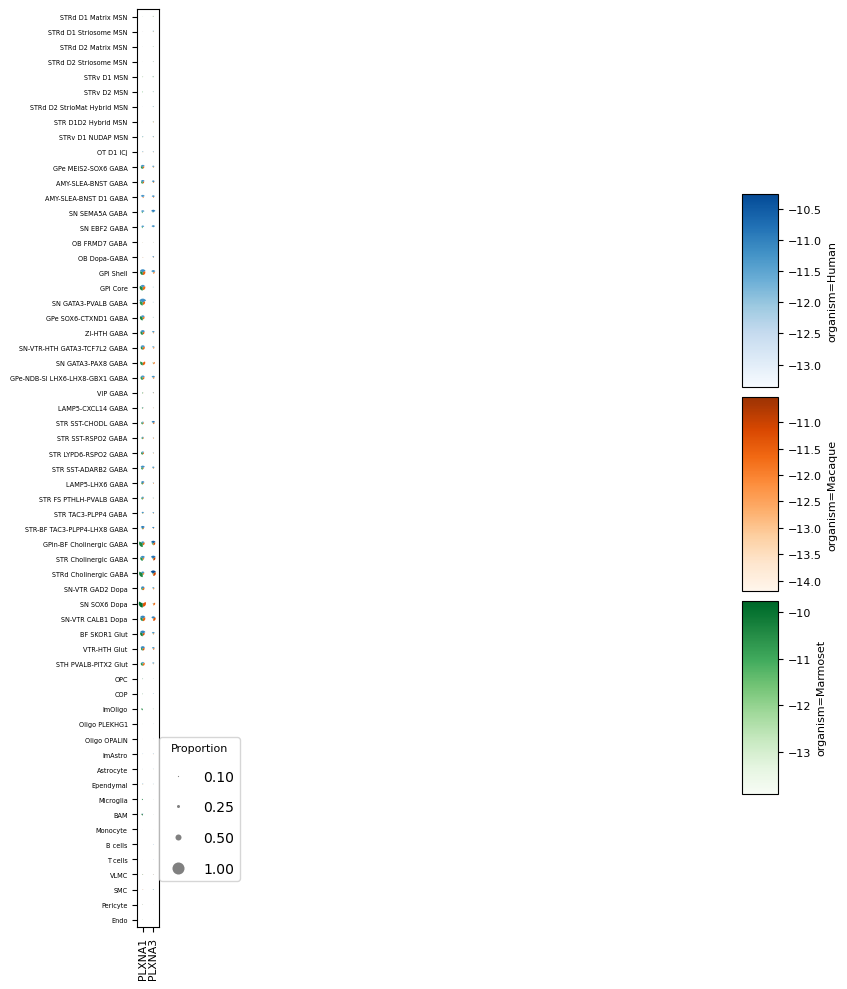

In [38]:
gene_order = ['PLXNA1','PLXNA3',]
ax,fig = antipode.plotting.pie_dotplot_xr(ads.sel(var=gene_order),row_dim='Group',col_dim='var',slice_dim='organism',
      scale_by='column', max_radius=0.4, figsize=(12, 10),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


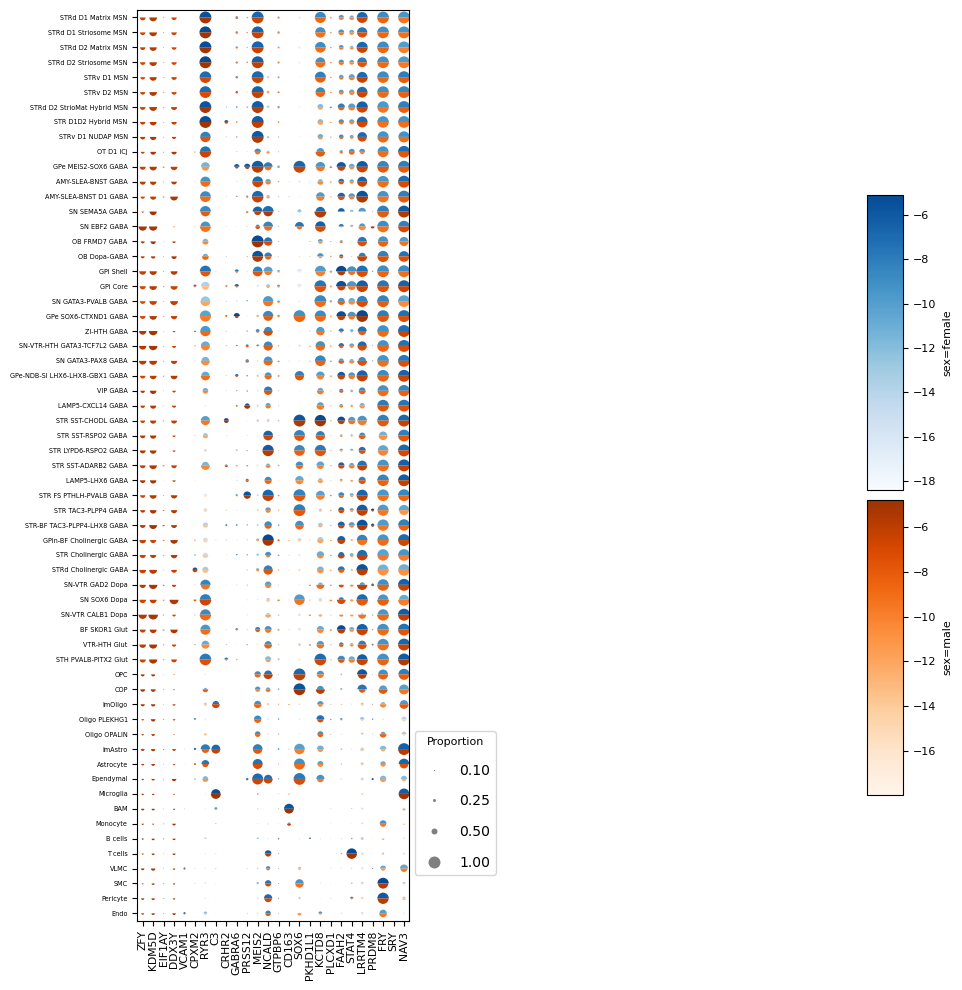

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


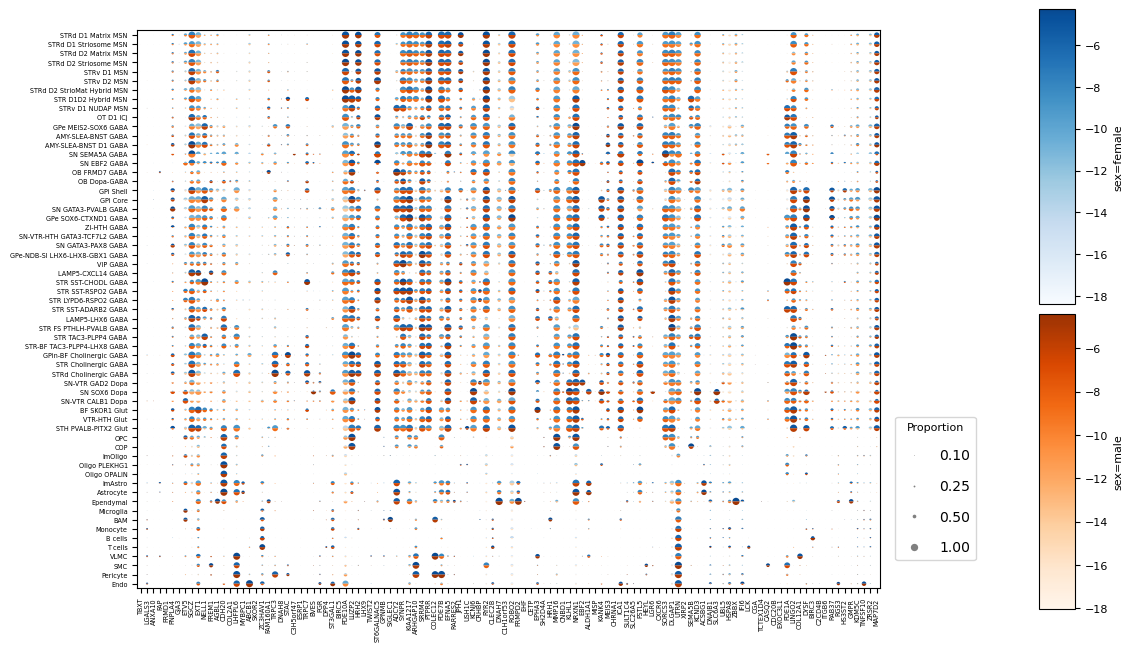

In [39]:
gene_order = antipode.post.uniqlist(list(itertools.chain(*up_genes.values())))
ax,fig = antipode.plotting.pie_dotplot_xr(sads.sel(var=gene_order),row_dim='Group',col_dim='var',slice_dim='sex',
      scale_by='column', max_radius=0.4, figsize=(12, 10),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

gene_order = antipode.post.uniqlist(list(itertools.chain(*down_genes.values())))
ax,fig = antipode.plotting.pie_dotplot_xr(sads.sel(var=gene_order),row_dim='Group',col_dim='var',slice_dim='sex',
      scale_by='column', max_radius=0.4, figsize=(12, 10),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

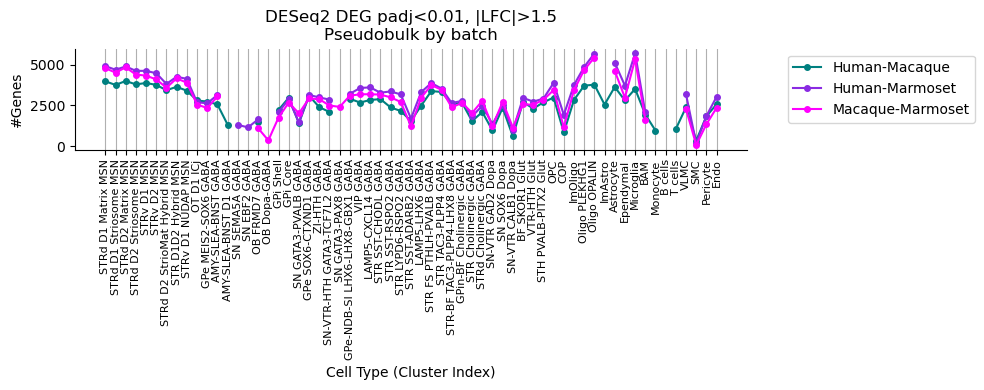

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os

# thresholds
padj_thresh = 0.01
lfc_thresh = 1.5

# counts per (contrast, cluster): padj<0.01 and |lfc|>1.5
cond = (deds["padj"] < padj_thresh) & (np.abs(deds["lfc"]) > lfc_thresh)
counts = cond.fillna(False).sum(dim="gene").where(lambda x: x > 0)  # zeros -> NaN

# cluster labels from the dataset (same order used when building deds)
cluster_labels = deds.coords[leaf_key].to_numpy()
x = np.arange(cluster_labels.size)

# optional: custom colors for specific contrasts
palette = {'Human-Macaque':'teal','Human-Marmoset':'blueviolet','Macaque-Marmoset':'fuchsia','Human-Mouse':'firebrick','Macaque-Mouse':'goldenrod'}

plt.figure(figsize=(10, 4))
for contrast in counts["contrast"].to_numpy():
    if 'sex' in contrast:
        continue
    y = counts.sel(contrast=contrast).to_numpy()
    color = palette.get(contrast, None)
    if color is None:
        plt.plot(x, y, marker='o', markersize=4, label=contrast)
    else:
        plt.plot(x, y, marker='o', markersize=4, label=contrast, c=color)

plt.xticks(ticks=x, labels=cluster_labels, rotation=90, fontsize=8)
plt.xlabel("Cell Type (Cluster Index)")
plt.ylabel("#Genes")
plt.title("DESeq2 DEG padj<0.01, |LFC|>1.5\nPseudobulk by batch")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x')
plt.savefig(os.path.join(sc.settings.figdir, 'de_per_group.pdf'), format='pdf')
plt.show()


In [23]:
pd.set_option('display.max_rows', 100)
vcs = adata.obs.groupby('organism')['Group'].value_counts().unstack().T

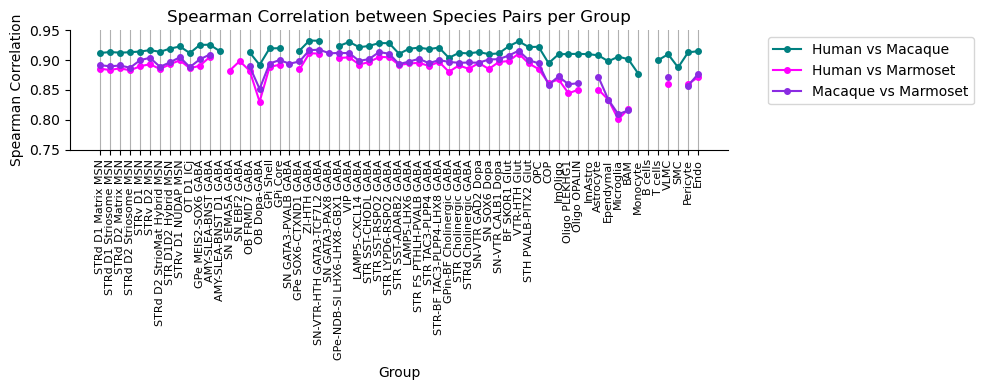

In [24]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import itertools

num_species = ads.dims[species_key]
num_clusters = ads.dims[leaf_key]
species_cats = adata.obs[species_key].cat.categories

# Generate all species pairs (combinations)
species_pairs = list(itertools.combinations(range(num_species), 2))
correlations = {pair: [] for pair in species_pairs}

# Compute Spearman correlation for each cell type for every species pair
for cluster in range(num_clusters):
    for pair in species_pairs:
        i, j = pair
        # Extract gene expression vectors for the current cell type
        if (vcs.iloc[cluster,i] > 50) &  (vcs.iloc[cluster,j] > 50):
            expr_i = ads['scalars'].data[i, cluster, :]
            expr_j = ads['scalars'].data[j, cluster, :]
            rho, _ = spearmanr(expr_i, expr_j)
            correlations[pair].append(rho)
        else:
            correlations[pair].append(np.nan)
palette = {'Human-Macaque':'teal','Human-Marmoset':'fuchsia','Macaque-Marmoset':'blueviolet','Human-Mouse':'firebrick','Macaque-Mouse':'goldenrod'}

# Create the line plot
x = np.arange(num_clusters)
plt.figure(figsize=(10, 4))
for i,(pair, corr_vals) in enumerate(correlations.items()):
    label = f"{species_cats[pair[0]]} vs {species_cats[pair[1]]}"
    plt.plot(x, corr_vals, marker='o',markersize=4, label=label,c=list(palette.values())[i])

plt.xticks(ticks=x, labels=adata.obs['Group'].cat.categories, rotation=90,fontsize=8)
plt.xlabel("Group")
plt.ylabel("Spearman Correlation")
plt.title("Spearman Correlation between Species Pairs per Group")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0.75, .95)
ax.grid(axis='x')
plt.savefig(os.path.join(sc.settings.figdir, 'spearman_correlations_group.pdf'), format='pdf')
plt.show()


 40%|███▉      | 73/183 [00:03<00:05, 21.82it/s]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


100%|██████████| 183/183 [00:04<00:00, 42.60it/s]


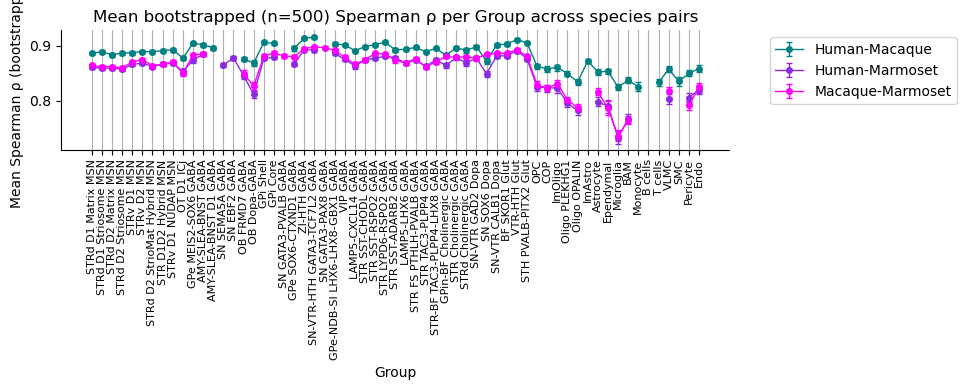

In [25]:
# bootstrap for correlations

rng = np.random.default_rng(42)
min_cells = 50 # less than this # get excluded all together
n_boot = 500 
n_per_group = 100

leaf_levels = list(ads.coords[leaf_key].values)
gene_names = list(ads.coords["var"].values)
species_cats = list(adata.obs[species_key].cat.categories)
coords = ads.coords

# species pairs by index in species_cats
species_pairs = list(itertools.combinations(range(len(species_cats)), 2))

counts = pd.crosstab(adata.obs[leaf_key], adata.obs[species_key]).reindex(index=leaf_levels, columns=species_cats, fill_value=0)

# helper: sample exactly n_per_group per leaf (with replacement)
def sample_indices_per_species_leaf(adata, species_key, leaf_key, n_per_group, rng):
    idx = []
    obs = adata.obs
    for sp in adata.obs[species_key].cat.categories:
        for leaf in adata.obs[leaf_key].cat.categories:
            pool = obs.index[(obs[species_key] == sp) & (obs[leaf_key] == leaf)].to_numpy()
            if pool.size == 0:
                continue
            take = rng.choice(pool, size=n_per_group, replace=True)
            idx.append(take)
    return np.concatenate(idx).astype(str) if idx else np.array([], dtype=str)

def rho_spearman(x, y):
    r, _ = spearmanr(x, y, nan_policy="omit")
    return r

if not  os.path.exists(os.path.join(sc.settings.figdir, f'boot_spearman_pairs_{leaf_key}.csv')):
    # boot results: dict[(i,j)] -> DataFrame (leaf × boot)
    boot_rhos = {pair: pd.DataFrame(index=leaf_levels, columns=np.arange(n_boot), dtype=float)
                 for pair in species_pairs}
    
    for b in range(n_boot):
        sel = sample_indices_per_species_leaf(adata, species_key, leaf_key, n_per_group, rng)
        if sel.size == 0:
            raise ValueError("No cells selected in bootstrap; check group labels present in adata.obs.")
        adb = adata[sel, :]
    
        lrm_b, _ = antipode.model_functions.get_real_leaf_means(
            adb, species_key, leaf_key, layer=layer_key
        )
        lrm_b = xr.DataArray(
            lrm_b,
            dims=[species_key, leaf_key, "var"],
            coords=coords,
        )
        lrm_b = lrm_b.sel({leaf_key: leaf_levels, "var": gene_names, species_key: species_cats})
    
        for leaf in leaf_levels:
            for (i, j) in species_pairs:
                si, sj = species_cats[i], species_cats[j]
                if (counts.loc[leaf, si] < min_cells) or (counts.loc[leaf, sj] < min_cells):
                    boot_rhos[(i, j)].loc[leaf, b] = np.nan
                    continue
                xi = lrm_b.sel({species_key: si, leaf_key: leaf}).to_numpy().ravel()
                xj = lrm_b.sel({species_key: sj, leaf_key: leaf}).to_numpy().ravel()
                boot_rhos[(i, j)].loc[leaf, b] = rho_spearman(xi, xj)
    
    # summarize to long table
    rows = []
    for (i, j), df in boot_rhos.items():
        mean_rho = df.mean(axis=1)
        sd_rho = df.std(axis=1, ddof=1)
        q025 = df.quantile(0.025, axis=1)
        q975 = df.quantile(0.975, axis=1)
        pair_label = f"{species_cats[i]}-{species_cats[j]}"
        tmp = pd.DataFrame({
            "leaf": df.index,
            "pair": pair_label,
            "mean_rho": mean_rho.values,
            "sd_rho": sd_rho.values,
            "p2p5": q025.values,
            "p97p5": q975.values,
            "n_boot": n_boot
        })
        rows.append(tmp)
    summary = pd.concat(rows, ignore_index=True)
    summary.to_csv(os.path.join(sc.settings.figdir, f'boot_spearman_pairs_{leaf_key}.csv'))
else:
    summary = pd.read_csv(os.path.join(sc.settings.figdir, f'boot_spearman_pairs_{leaf_key}.csv'),index_col=0)

# line plot of mean bootstrapped correlations per pair across leaves
palette = {
    'Human-Macaque':'teal','Human-Marmoset':'blueviolet','Macaque-Marmoset':'fuchsia',
    'Human-Mouse':'firebrick','Macaque-Mouse':'goldenrod','Marmoset-Mouse':'darkorange'
}
x = np.arange(len(leaf_levels))
plt.figure(figsize=(10, 4))

for pair_label, gdf in summary.groupby("pair"):
    gdf = gdf.set_index("leaf").reindex(leaf_levels)
    y = gdf["mean_rho"].to_numpy()
    lo = gdf["p2p5"].to_numpy()
    hi = gdf["p97p5"].to_numpy()

    # m = np.isfinite(y) & np.isfinite(lo) & np.isfinite(hi)
    # if m.sum() == 0:
    #     continue

    # xm, ym, lom, him = x[m], y[m], lo[m], hi[m]
    xm, ym, lom, him = x, y, lo, hi
    c = palette.get(pair_label, None)

    yerr = np.vstack([ym - lom, him - ym])
    plt.errorbar(xm, ym, yerr=yerr, fmt='-o', capsize=2, markersize=4, linewidth=1,
                 color=c if c else None, label=pair_label)


plt.xticks(ticks=x, labels=leaf_levels, rotation=90, fontsize=8)
plt.xlabel(leaf_key)
plt.ylabel("Mean Spearman ρ (bootstrapped)")
plt.title(f"Mean bootstrapped (n={n_boot}) Spearman ρ per {leaf_key} across species pairs")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x')
plt.savefig(os.path.join(sc.settings.figdir, f'boot_spearman_pairs_{leaf_key}.pdf'), format='pdf')
plt.show()

/scratch/fast/4133714/ipykernel_954204/724600060.py:20: RuntimeWarning: Mean of empty slice
  rho = np.nanmean(np.nanmean(np.abs(centered_species[:, cluster, :]),0),-1)


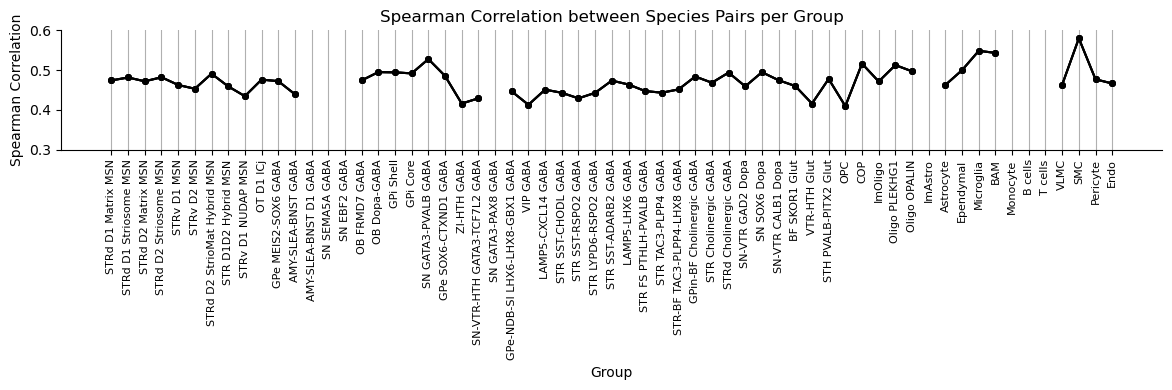

In [44]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import itertools

num_species = ads.dims[species_key]
num_clusters = ads.dims[leaf_key]
species_cats = adata.obs[species_key].cat.categories

# Generate all species pairs (combinations)
species_pairs = list(itertools.combinations(range(num_species), 2))
correlations = {pair: [] for pair in species_pairs}

centered_species = ads['scalars'].data - ads['scalars'].data.mean(0)[np.newaxis,...]

# Compute Spearman correlation for each cell type for every species pair
for cluster in range(num_clusters):
    for pair in species_pairs:
        i, j = pair
        # Extract gene expression vectors for the current cell type
        rho = np.nanmean(np.nanmean(np.abs(centered_species[:, cluster, :]),0),-1)
        correlations[pair].append(rho)
palette = {'Human-Macaque':'teal','Human-Marmoset':'fuchsia','Macaque-Marmoset':'blueviolet','Human-Mouse':'firebrick','Macaque-Mouse':'goldenrod'}

# Create the line plot
x = np.arange(num_clusters)
plt.figure(figsize=(12, 4))
for i,(pair, corr_vals) in enumerate(correlations.items()):
    label = f"{species_cats[pair[0]]} vs {species_cats[pair[1]]}"
    plt.plot(x, corr_vals, marker='o',markersize=4,c='black')

plt.xticks(ticks=x, labels=ads.coords['Group'].data, rotation=90,fontsize=8)
plt.xlabel("Group")
plt.ylabel("Spearman Correlation")
plt.title("Spearman Correlation between Species Pairs per Group")
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0.3, 0.6)
ax.grid(axis='x')
# plt.savefig(os.path.join(sc.settings.figdir, 'spearman_correlations_group.pdf'), format='pdf')
plt.show()

In [47]:
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import gseapy as gp

#deds is the de xarray dataset

padj_thresh = 0.05
lfc_thresh  = 1.0
min_query   = 5
gene_set_library = 'GO_Biological_Process_2025'

# prefetch gene sets to make faster
gs_dict = gp.get_library(name=gene_set_library)  # dict: term -> [genes]
if not isinstance(gs_dict, dict): #in case it's a lol
    gs_dict = {k: v for k, v in gs_dict}

# gs_dict = {k:v for k,v in gs_dict.items() if len(gs_dict[k])>5} #by hand filter
# gs_dict = {k:v for k,v in gs_dict.items() if len(gs_dict[k])<100}

cell_types = deds.coords['Group'].data
all_genes = deds.coords['gene'].data

geom_enrichment_results = {}

for c in deds.coords['contrast'].data:
    pair_key = c
    geom_enrichment_results[pair_key] = {}

    for k, cell_type in tqdm(enumerate(cell_types), total=len(cell_types)):
        try:
            lfc  = deds['lfc'].sel(contrast=c,Group=cell_type).data
            padj = deds['padj'].sel(contrast=c,Group=cell_type).data

            valid = ~np.isnan(padj)
            if valid.sum() < 10:
                continue

            # background/universe for this contrast × cell type
            universe = list(all_genes[valid])

            up_genes   = list(all_genes[valid & (padj < padj_thresh) & (lfc >  lfc_thresh)])
            down_genes = list(all_genes[valid & (padj < padj_thresh) & (lfc < -lfc_thresh)])

            dfs = []
            for direction, glist in (("up", up_genes), ("down", down_genes)):
                if len(glist) < min_query:
                    continue
                # ORA (hypergeometric) with offline gene sets + explicit background
                enr = gp.enrich(
                    gene_list=glist,
                    gene_sets=gs_dict,
                    background=universe,   
                    outdir=None,
                    verbose=False,
                )  
                if enr is None or enr.results is None or enr.results.empty:
                    continue
                df = enr.results.copy()
                df.insert(0, "direction", direction)
                dfs.append(df)

            if dfs:
                res_df = pd.concat(dfs, ignore_index=True)
                # tidy sort
                res_df = res_df.sort_values(["direction", "Adjusted P-value", "P-value"])
                geom_enrichment_results[pair_key][cell_type] = res_df.reset_index(drop=True)

        except Exception as e:
            print(f"{pair_key} / {cell_type}: {e}")


100%|██████████| 61/61 [00:00<00:00, 107.74it/s]


In [ ]:
geom_enrichment_results

In [48]:
for k in geom_enrichment_results['Macaque-Mouse'].keys():
    print(k)
    print(geom_enrichment_results['Macaque-Mouse'][k].loc[geom_enrichment_results['Macaque-Mouse'][k]['Adjusted P-value']<0.01].sort_values('Combined Score'))

KeyError: 'Macaque-Mouse'

In [ ]:
geom_enrichment_results['Macaque-Mouse']['Glut-D-9'].sort_values('Combined Score')

In [ ]:
seaborn.boxplot(x=geom_enrichment_results['Macaque-Mouse']['Glut-D-9']['direction'],y=geom_enrichment_results['Macaque-Mouse']['Glut-D-9']['Odds Ratio'])

In [ ]:
translation_genes = [x for x in gs_dict['ERBB4 Signaling Pathway (GO:0038130)'] if x in adata.var.index]
gene_order = translation_genes#geom_enrichment_results['Human_vs_Macaque']['Glut-D-4'].loc[0]['Genes'].split(';')[0:60]
antipode.plotting.pie_dotplot_xr(ads.isel(organism_name=[0,2,1]).sel(var=gene_order),row_dim='Group',col_dim='var',slice_dim=species_key,
      scale_by='column', max_radius=0.4, figsize=(8, 6),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as seaborn
import matplotlib.pyplot as plt
import re

def _overlap_numer(x):
    # gseapy Overlap is like "23/150"
    try:
        m = re.match(r"^\s*(\d+)\s*/\s*(\d+)\s*$", str(x))
        return int(m.group(1)) if m else np.nan
    except Exception:
        return np.nan

def dotplot_top_terms_hypergeo(
    enrichment_results,
    title="",
    fdr_col="Adjusted P-value",
    term_col="Term",
    direction_col="direction",
    group_regex='',
    term_regex='',
    group_order=None,
    top_n=10,
    fdr_thresh=0.10,
    outfile=None
):
    frames = []
    for group, df in enrichment_results.items():
        x = df.copy()
        x["Group"] = group
        frames.append(x)
    long = pd.concat(frames, ignore_index=True)

    long = long.loc[long['Group'].str.contains(group_regex, regex=True)]
    long = long.loc[long['Term'].str.contains(term_regex, regex=True)]
        
    long[fdr_col] = pd.to_numeric(long[fdr_col], errors="coerce")
    long["overlap_num"] = long["Overlap"].map(_overlap_numer)
    long = long.dropna(subset=[term_col, fdr_col, direction_col])

    agg = (long.groupby(term_col)
                .agg(min_fdr=(fdr_col, "min"),
                     max_overlap=("Combined Score", "max"))
                .sort_values(["min_fdr", "max_overlap"], ascending=[True, False])
                .reset_index())

    sig = agg[agg["min_fdr"] <= fdr_thresh]
    if len(sig) >= top_n:
        top_terms = sig.head(top_n)[term_col].tolist()
    else:
        need = top_n - len(sig)
        extra = agg.loc[~agg[term_col].isin(sig[term_col])].head(need)
        top_terms = pd.concat([sig[[term_col]], extra[[term_col]]])[term_col].tolist()

    dfp = long[long[term_col].isin(top_terms)].copy()
    if dfp.empty:
        print("No terms to plot.")
        return

    # Set size to zero if not significant
    dfp["neglog10_fdr"] = 0.0
    sig_mask = dfp[fdr_col] <= fdr_thresh
    dfp.loc[sig_mask, "neglog10_fdr"] = -np.log10(
        dfp.loc[sig_mask, fdr_col].clip(lower=1e-300)
    )

    term_order = (dfp.groupby(term_col)
                     .agg(min_fdr=(fdr_col, "min"))
                     .sort_values("min_fdr")
                     .index.tolist())[::-1]

    if group_order is None:
        group_order = sorted(dfp["Group"].unique())

    dfp[term_col] = pd.Categorical(dfp[term_col], categories=term_order, ordered=True)
    dfp["Group"]  = pd.Categorical(dfp["Group"],  categories=group_order, ordered=True)

    palette = {"up": "red", "down": "blue"}

    plt.figure(figsize=(0.8 * len(group_order), 0.33 * len(term_order)))
    ax = seaborn.scatterplot(
        data=dfp,
        x="Group",
        y=term_col,
        hue=direction_col,
        size="neglog10_fdr",
        palette=palette,
        sizes=(0, 300),   # now zero size for insignificant
        linewidth=0.3,
        edgecolor="black",
        alpha=0.9
    )

    ax.set_xlabel("")
    ax.set_ylabel("GO term")
    plt.xticks(rotation=60, ha="right")
    plt.title(f"{title}")

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight", dpi=300)
    plt.show()




In [ ]:
dotplot_top_terms_hypergeo(geom_enrichment_results['sex:male-female'], top_n=50, fdr_thresh=0.1,#term_regex='0051056|0098742|0006412|1902531|0045333',
                        group_order=None, outfile=None)

In [ ]:
dotplot_top_terms_hypergeo(geom_enrichment_results["Human-Macaque"], top_n=50, fdr_thresh=0.1,group_regex='GABA|Glut',#term_regex='0051056|0098742|0006412|1902531|0045333',
                        group_order=None, outfile=None)

In [ ]:
dotplot_top_terms_hypergeo(geom_enrichment_results["Macaque-Mouse"], top_n=50, fdr_thresh=0.05,#term_regex='0051056|0098742|0006412|1902531|0045333',
                        group_order=None, outfile=None)

In [ ]:
same_sign = (np.sign(deds['lfc'].sel(contrast='Human-Mouse')) == np.sign(deds['lfc'].sel(contrast='Macaque-Mouse')))
sig = ((deds['padj'].sel(contrast='Human-Mouse')<0.05) & (deds['padj'].sel(contrast='Macaque-Mouse')<0.05))
primate_direction = np.sign(deds['lfc'].sel(contrast='Macaque-Mouse')) * (same_sign & sig)

In [ ]:
primate_enrich = {}
for k, cell_type in tqdm(enumerate(cell_types), total=len(cell_types)):
    try:
        # background/universe for this contrast × cell type
        universe = list(all_genes)

        up_genes   = list(all_genes[primate_direction.sel(Group=cell_type)>0])
        down_genes = list(all_genes[primate_direction.sel(Group=cell_type)<0])

        dfs = []
        for direction, glist in (("up", up_genes), ("down", down_genes)):
            if len(glist) < min_query:
                continue
            # ORA (hypergeometric) with offline gene sets + explicit background
            enr = gp.enrich(
                gene_list=glist,
                gene_sets=gs_dict,
                background=universe,   
                outdir=None,
                verbose=False,
            )  
            if enr is None or enr.results is None or enr.results.empty:
                continue
            df = enr.results.copy()
            df.insert(0, "direction", direction)
            dfs.append(df)

        if dfs:
            res_df = pd.concat(dfs, ignore_index=True)
            # tidy sort
            res_df = res_df.sort_values(["direction", "Adjusted P-value", "P-value"])
            primate_enrich[cell_type] = res_df.reset_index(drop=True)

    except Exception as e:
        print(f"{pair_key} / {cell_type}: {e}")


In [ ]:
dotplot_top_terms_hypergeo(primate_enrich, top_n=50, fdr_thresh=0.05,group_regex='GABA|Glut',#term_regex='0051056|0098742|0006412|1902531|0045333',
                        group_order=None, outfile=None)

In [ ]:
same_sign = (np.sign(deds['lfc'].sel(contrast='Human-Mouse')) == np.sign(deds['lfc'].sel(contrast='Human-Macaque')))
sig = ((deds['padj'].sel(contrast='Human-Mouse')<0.05) & (deds['padj'].sel(contrast='Human-Macaque')<0.05))
human_direction = np.sign(deds['lfc'].sel(contrast='Human-Macaque')) * (same_sign & sig)

In [ ]:
human_enrich = {}
for k, cell_type in tqdm(enumerate(cell_types), total=len(cell_types)):
    try:
        # background/universe for this contrast × cell type
        universe = list(all_genes)

        up_genes   = list(all_genes[human_direction.sel(Group=cell_type)>0])
        down_genes = list(all_genes[human_direction.sel(Group=cell_type)<0])
        # print(len(up_genes),len(down_genes))
        dfs = []
        for direction, glist in (("up", up_genes), ("down", down_genes)):
            if len(glist) < min_query:
                continue
            # ORA (hypergeometric) with offline gene sets + explicit background
            enr = gp.enrich(
                gene_list=glist,
                gene_sets=gs_dict,
                background=universe,   
                outdir=None,
                verbose=False,
            )  
            if enr is None or enr.results is None or enr.results.empty:
                continue
            df = enr.results.copy()
            df.insert(0, "direction", direction)
            dfs.append(df)

        if dfs:
            res_df = pd.concat(dfs, ignore_index=True)
            # tidy sort
            res_df = res_df.sort_values(["direction", "Adjusted P-value", "P-value"])
            human_enrich[cell_type] = res_df.reset_index(drop=True)

    except Exception as e:
        print(f"{pair_key} / {cell_type}: {e}")


In [ ]:
dotplot_top_terms_hypergeo(human_enrich, top_n=50, fdr_thresh=0.05,group_regex='GABA|Glut',#term_regex='0051056|0098742|0006412|1902531|0045333',
                        group_order=None, outfile=None)

In [ ]:
def deduplicate_gene_dict(disease_gene_dict):
    seen = {}
    for disease, genes in disease_gene_dict.items():
        # Use frozenset so that gene order doesn't matter
        key = frozenset(genes)
        if key not in seen:
            seen[key] = disease
    # Rebuild dictionary with only one disease per unique set of genes
    deduped = {disease: list(key) for key, disease in seen.items()}
    return deduped


import gseapy
dis_set = pd.Series(gseapy.get_library('DisGeNET').keys())
dgn = gseapy.get_library('DisGeNET')
# pain_disorders = dgn
pain_disorders = {k:dgn[k] for k in dis_set[dis_set.str.lower().str.contains('^pain disorder$|congenital pain insensitivity|^chronic pain$|^neuralgia$|fibromyalgia|^allodynia$|restless leg|central sensitization|movement disorders|^spastic paraplegia$|stiff-person|hyperekplexia|^amyotrophic lateral sclerosis$|^multiple sclerosis$|neurofibromatosis 1|^hyperalgesia$|ataxia, spinocerebellar|ataxia, sensory|neuropathic pruritus',regex=True)]}
# pain_disorders = {k:dgn[k] for k in dis_set[dis_set.str.lower().str.contains('pain disorder|chronic pain|neuralgia|absence of pain sensation|fibromyalgia|allodynia|restless leg|central sensitization|movement disorders|spastic paraplegia|stiff-person|hyperekplexia',regex=True)]}
pain_disorders = deduplicate_gene_dict(pain_disorders)

In [ ]:
def jaccard_heatmap(d):
    # Convert values to sets
    sets = {k: set(v) for k, v in d.items()}
    keys = list(sets.keys())

    # Initialize empty matrix
    n = len(keys)
    mat = np.zeros((n, n))

    # Compute Jaccard index for each pair
    for i, k1 in tqdm(enumerate(keys)):
        for j, k2 in enumerate(keys):
            inter = len(sets[k1] & sets[k2])
            union = len(sets[k1] | sets[k2])
            mat[i, j] = inter / union if union > 0 else np.nan

    # Put into DataFrame
    jdf = pd.DataFrame(mat, index=keys, columns=keys)

    # Plot heatmap
    seaborn.clustermap(
        jdf,
        cmap="coolwarm",
        center=0.5,
        row_cluster=False,
        col_cluster=False,
    )
    plt.show()
jaccard_heatmap(pain_disorders)

In [ ]:
translation_genes = [x for x in pain_disorders['Neuralgia'] if x in adata.var.index]
gene_order = translation_genes#geom_enrichment_results['Human_vs_Macaque']['Glut-D-4'].loc[0]['Genes'].split(';')[0:60]
antipode.plotting.pie_dotplot_xr(ads.isel(organism_name=[0,2,1]).sel(var=gene_order),row_dim='Group',col_dim='var',slice_dim=species_key,
      scale_by='column', max_radius=0.4, figsize=(12, 10),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

In [ ]:
human_enrich_pain = {}
for k, cell_type in tqdm(enumerate(cell_types), total=len(cell_types)):
    try:
        # background/universe for this contrast × cell type
        universe = list(all_genes)

        up_genes   = list(all_genes[human_direction.sel(Group=cell_type)>0])
        down_genes = list(all_genes[human_direction.sel(Group=cell_type)<0])

        dfs = []
        for direction, glist in (("up", up_genes), ("down", down_genes)):
            if len(glist) < min_query:
                continue
            # ORA (hypergeometric) with offline gene sets + explicit background
            enr = gp.enrich(
                gene_list=glist,
                gene_sets=pain_disorders,
                background=universe,   
                outdir=None,
                verbose=False,
            )  
            if enr is None or enr.results is None or enr.results.empty:
                continue
            df = enr.results.copy()
            df.insert(0, "direction", direction)
            dfs.append(df)

        if dfs:
            res_df = pd.concat(dfs, ignore_index=True)
            # tidy sort
            res_df = res_df.sort_values(["direction", "Adjusted P-value", "P-value"])
            human_enrich_pain[cell_type] = res_df.reset_index(drop=True)

    except Exception as e:
        print(f"{pair_key} / {cell_type}: {e}")

In [ ]:
seaborn.histplot(data=human_enrich_pain['Glut-D-2'],x='Combined Score',hue='direction')

In [ ]:
dotplot_top_terms_hypergeo(human_enrich_pain, top_n=15, fdr_thresh=0.1,#term_regex='Diabetic Neuralgia|^Neuralgia$|Neuralgia, Atypical',
                        group_order=None, outfile=None)

In [ ]:
sig = ((deds['padj'].sel(contrast='Macaque-Mouse')<0.05) & (np.abs(deds['lfc'].sel(contrast='Macaque-Mouse'))>1.5))
qm_direction = np.sign(deds['lfc'].sel(contrast='Macaque-Mouse')) * (sig)

In [ ]:
qm_enrich_pain = {}
for k, cell_type in tqdm(enumerate(cell_types), total=len(cell_types)):
    try:
        # background/universe for this contrast × cell type
        universe = list(all_genes)

        up_genes   = list(all_genes[qm_direction.sel(Group=cell_type)>0])
        down_genes = list(all_genes[qm_direction.sel(Group=cell_type)<0])

        dfs = []
        for direction, glist in (("up", up_genes), ("down", down_genes)):
            if len(glist) < min_query:
                continue
            # ORA (hypergeometric) with offline gene sets + explicit background
            enr = gp.enrich(
                gene_list=glist,
                gene_sets=pain_disorders,
                background=universe,   
                outdir=None,
                verbose=False,
            )  
            if enr is None or enr.results is None or enr.results.empty:
                continue
            df = enr.results.copy()
            df.insert(0, "direction", direction)
            dfs.append(df)

        if dfs:
            res_df = pd.concat(dfs, ignore_index=True)
            # tidy sort
            res_df = res_df.sort_values(["direction", "Adjusted P-value", "P-value"])
            qm_enrich_pain[cell_type] = res_df.reset_index(drop=True)

    except Exception as e:
        print(f"{pair_key} / {cell_type}: {e}")

In [ ]:
primate_enrich_pain = {}
for k, cell_type in tqdm(enumerate(cell_types), total=len(cell_types)):
    try:
        # background/universe for this contrast × cell type
        universe = list(all_genes)

        up_genes   = list(all_genes[primate_direction.sel(Group=cell_type)>0])
        down_genes = list(all_genes[primate_direction.sel(Group=cell_type)<0])

        dfs = []
        for direction, glist in (("up", up_genes), ("down", down_genes)):
            if len(glist) < min_query:
                continue
            # ORA (hypergeometric) with offline gene sets + explicit background
            enr = gp.enrich(
                gene_list=glist,
                gene_sets=pain_disorders,
                background=universe,   
                outdir=None,
                verbose=False,
            )  
            if enr is None or enr.results is None or enr.results.empty:
                continue
            df = enr.results.copy()
            df.insert(0, "direction", direction)
            dfs.append(df)

        if dfs:
            res_df = pd.concat(dfs, ignore_index=True)
            # tidy sort
            res_df = res_df.sort_values(["direction", "Adjusted P-value", "P-value"])
            primate_enrich_pain[cell_type] = res_df.reset_index(drop=True)

    except Exception as e:
        print(f"{pair_key} / {cell_type}: {e}")

In [ ]:
dotplot_top_terms_hypergeo(primate_enrich_pain, top_n=15, fdr_thresh=0.1,
                        group_order=None, outfile=None)

In [ ]:
seaborn.histplot(ads['scalars'].data.flatten())

In [ ]:
seaborn.histplot(ads['scalars'].var('Group').data.flatten())

In [ ]:
ads['max_scaled'] = ads['scalars'] - ads['scalars'].max('Group',skipna=True).max(species_key,skipna=True)

In [ ]:
seaborn.histplot((ads['scalars'].max('Group',skipna=True) - ads['scalars'].min('Group',skipna=True)).data.flatten())

In [ ]:
seaborn.histplot(ads['max_scaled'].data.flatten())

In [ ]:
seaborn.histplot(ads['max_scaled'].data.flatten())

In [ ]:
cell_types = ads.coords['Group'].data
exp_thresh = -1
genes = ads.coords['var'].data
min_query = 4

expr_enrich = {}

for s in ads.coords[species_key].data:
    expr_enrich[s] = {}
    for k, cell_type in tqdm(enumerate(cell_types),total=len(cell_types)):
        # mask = ads['max_scaled'].sel({species_key:s,'Group':cell_type}).data > exp_thresh
        mask = np.argsort(np.argsort(np.log(np.exp(ads['max_scaled']).median(species_key,skipna=True).sel({leaf_key:cell_type})).data,-1),-1) > (len(genes)-2001)
        glist = list(all_genes[mask])
        universe = list(genes)
        if len(glist) > min_query:
            enr = gp.enrich(
                gene_list=glist,
                gene_sets=gs_dict,
                background=universe,   
                outdir=None,
                verbose=False,
            ) 
            if enr is None or enr.results is None or enr.results.empty:
                continue
            df = enr.results.copy()
            df['direction'] = 'up'
            expr_enrich[s][cell_type] = df


In [ ]:
dotplot_top_terms_hypergeo(expr_enrich['Macaque'], top_n=50, fdr_thresh=0.05,group_regex='GABA|Glut',#term_regex='0051056|0098742|0006412|1902531|0045333',
                        group_order=None, outfile=None,)

In [ ]:
ax = seaborn.ecdfplot(hue='Group',x='scalars',data=(ads['scalars']+np.log(1e6)).sel(organism_name='Macaque').to_dataframe())
plt.xlabel('pseudobulk log cpm')
seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
cell_types = ads.coords['Group'].data
exp_thresh = -1
genes = ads.coords['var'].data
min_query = 4

expr_disorder_enrich = {}

for k, cell_type in tqdm(enumerate(cell_types),total=len(cell_types)):
    # mask = np.log(np.exp(ads['max_scaled']).median(species_key,skipna=True).sel({'Group':cell_type})).data > exp_thresh
    mask = np.argsort(np.argsort(np.log(np.exp(ads['max_scaled']).median(species_key,skipna=True).sel({leaf_key:cell_type})).data,-1),-1) > (len(genes)-2001)
    glist = list(all_genes[mask])
    universe = list(genes)
    if len(glist) > min_query:
        print(cell_type,len(glist))
        enr = gp.enrich(
            gene_list=glist,
            gene_sets=pain_disorders,
            background=universe,   
            outdir=None,
            verbose=False,
        )  
        if enr is None or enr.results is None or enr.results.empty:
            continue
        df = enr.results.copy()
        df['direction'] = 'up'
        expr_disorder_enrich[cell_type] = df


In [ ]:
dotplot_top_terms_hypergeo(expr_disorder_enrich, top_n=6, fdr_thresh=0.1,group_regex='GABA|Glut',#term_regex='0051056|0098742|0006412|1902531|0045333',
                        group_order=None, outfile=None,)


In [ ]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import math
import matplotlib.patheffects as pe


def plot_tile_heatmap(
    data, dim_0_names, dim_1_names, dim_2_names, mini_grid_dims=None, 
    cell_size=1, cmap_name='tab20', heavy_linewidth=2, light_linewidth=0.2,
    font_size=10, save_path=None,
    legend_square_size=0.4, legend_font_size=7, legend_pad=0.03,
    missing_color=(0.8, 0.8, 0.8)  # grey for NaNs
):
    n_rows_data, n_cols_data, n_ligands = data.shape
    if len(dim_0_names) != n_rows_data:
        raise ValueError(f"Expected {n_rows_data} row labels, got {len(dim_0_names)}.")
    if len(dim_1_names) != n_cols_data:
        raise ValueError(f"Expected {n_cols_data} column labels, got {len(dim_1_names)}.")

    if mini_grid_dims is None:
        n_rows = max(int(np.floor(np.sqrt(n_ligands))), 1)
        n_cols = int(np.ceil(n_ligands / n_rows))
    else:
        n_rows, n_cols = mini_grid_dims

    cmap = plt.get_cmap(cmap_name)
    base_colors = [cmap(i / n_ligands) for i in range(n_ligands)]

    fig, ax = plt.subplots(figsize=(n_cols_data * cell_size, n_rows_data * cell_size))
    ax.set_xlim(0, n_cols_data * cell_size)
    ax.set_ylim(0, n_rows_data * cell_size)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    for i in tqdm(range(n_rows_data)):
        for j in range(n_cols_data):
            cell_x = j * cell_size
            cell_y = i * cell_size
            ax.add_patch(patches.Rectangle((cell_x, cell_y), cell_size, cell_size,
                                           fill=False, edgecolor='black', lw=heavy_linewidth))
            tile_w = cell_size / n_cols
            tile_h = cell_size / n_rows
            for k in range(n_ligands):
                mini_row = k // n_cols
                mini_col = k % n_cols
                tile_x = cell_x + mini_col * tile_w
                tile_y = cell_y + mini_row * tile_h
                v = data[i, j, k]
                if np.isnan(v):
                    color = missing_color
                else:
                    base = np.array(base_colors[k][:3])
                    color = (1 - v) * np.array([1, 1, 1]) + v * base
                ax.add_patch(patches.Rectangle((tile_x, tile_y), tile_w, tile_h,
                                               facecolor=color, edgecolor='gray', lw=light_linewidth))

    xticks = np.arange(cell_size/2, n_cols_data * cell_size, cell_size)
    yticks = np.arange(cell_size/2, n_rows_data * cell_size, cell_size)
    ax.set_xticks(xticks); ax.set_yticks(yticks)
    ax.set_xticklabels(dim_1_names, rotation=90)
    ax.set_yticklabels(dim_0_names)
    ax.tick_params(axis='both', which='major', labelsize=font_size)

    pos = ax.get_position()
    fig_w, fig_h = fig.get_size_inches()
    legend_w = (legend_square_size * n_cols) / fig_w
    legend_h = (legend_square_size * n_rows * 0.4) / fig_h
    x0 = pos.x1 + legend_pad
    y0 = pos.y0 + (pos.height - legend_h) / 2
    legend_ax = fig.add_axes([x0, y0, legend_w, legend_h])
    legend_ax.set_xlim(0, n_cols); legend_ax.set_ylim(0, n_rows)
    legend_ax.invert_yaxis(); legend_ax.axis('off')

    for k, name in enumerate(dim_2_names):
        col = k % n_cols; row = k // n_cols
        legend_ax.text(col + 0.5, row + 0.5, name,
                       ha='center', va='center',
                       color=base_colors[k], fontsize=legend_font_size,
                       fontweight='bold',
                       path_effects=[pe.withStroke(linewidth=0.3, foreground="black")],
                       wrap=True)

    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, format='pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()



import numpy as np
import pandas as pd
import xarray as xr

def _pick_pcol(df, prefer_adjusted=True):
    if prefer_adjusted and "Adjusted P-value" in df.columns:
        return "Adjusted P-value"
    return "P-value" if "P-value" in df.columns else None

def build_tile_data_xr(
    dict_list, source_names, cap_logp=5.0, prefer_adjusted=True,
    term_order="by_max"  # "by_max" | "alpha"
):
    assert len(dict_list) == len(source_names)

    # collect axes
    groups = sorted({g for d in dict_list for g in d.keys()})
    terms  = sorted({
        str(t) for d in dict_list for g, df in d.items()
        if df is not None and len(df) and "Term" in df.columns
        for t in df["Term"].astype(str).values
    })
    sources = list(source_names)

    # init with NaN (missing stays NaN)
    data = np.full((len(terms), len(groups), len(sources)), np.nan, dtype=float)
    t_ix = {t:i for i,t in enumerate(terms)}
    g_ix = {g:i for i,g in enumerate(groups)}

    # fill per (term, group, source) with min p; map to -log10
    for s_idx, d in enumerate(dict_list):
        for g, df in d.items():
            if g not in g_ix or df is None or len(df) == 0:
                continue
            pcol = _pick_pcol(df, prefer_adjusted)
            if pcol is None:
                continue

            x = df.copy()
            x[pcol] = pd.to_numeric(x[pcol], errors="coerce")
            x = x.dropna(subset=["Term", pcol])

            # min p per term (ignores NaNs)
            per_term = x.groupby("Term", dropna=True)[pcol].min()

            gi = g_ix[g]
            for t, p in per_term.items():
                ti = t_ix.get(t)
                if ti is None:
                    continue

                # Explicit mapping:
                # - missing/NaN -> stay NaN (handled by init)
                # - p <= 0 or non-finite -> cap_logp
                # - else -> -log10(p)
                if pd.isna(p):
                    lp = np.nan
                elif (p <= 0) or (not np.isfinite(p)):
                    lp = cap_logp
                else:
                    lp = -np.log10(float(p))

                data[ti, gi, s_idx] = lp

    # replace non-finite with cap, clip, scale to [0,1]; preserve NaNs
    finite_mask = np.isfinite(data)
    data[finite_mask] = np.clip(data[finite_mask], 0.0, cap_logp)
    data_scaled = np.where(finite_mask, data / cap_logp, np.nan)

    da = xr.DataArray(
        data_scaled,
        dims=("term", "group", "source"),
        coords={"term": terms, "group": groups, "source": sources},
        name="intensity",
        attrs={"cap_logp": cap_logp, "prefer_adjusted": prefer_adjusted}
    )

    if term_order == "by_max":
        order = np.argsort(-np.nanmax(da.values, axis=(1, 2)))
        da = da.isel(term=order)

    return da

dict_list = [expr_disorder_enrich, qm_enrich_pain, primate_enrich_pain, human_enrich_pain]
source_names = ["GEx","QvM", "Primate", "Human"]

# build xarray
da = build_tile_data_xr(dict_list, source_names, cap_logp=3., prefer_adjusted=True, term_order="by_max")
da = da.sel(group=adata.obs['Group'].cat.categories)
da = da.sel(group=da.coords['group'][~da.coords['group'].str.contains('Schwann|Macrophages|Lymphocytes')])
# da[np.where(da.data<-np.log10(0.05))] = 0

# da = da.sel(term=['Movement Disorders', 'Spastic Paraplegia', 'Stiff-Person Syndrome','Restless Legs Syndrome',
        # 'Neuralgia', 'Chronic pain', 'Pain Disorder','Allodynia','Congenital Pain Insensitivity','Fibromyalgia'])
# optional: reorder
# da = da.reindex(term=desired_term_order)            # custom term order
# da = da.sel(group=[...])                            # subset groups
# da = da.reindex(group=[...], source=[...])          # full control

palette = ['firebrick','darkgoldenrod','darkorange','deeppink']
cmap = matplotlib.colors.ListedColormap(list(palette),name="contrast_pal")
try: matplotlib.colormaps.unregister(name="contrast_pal")
except: pass
matplotlib.colormaps.register(name="contrast_pal",cmap=cmap)

# plot: pass numpy array + coords
plot_tile_heatmap(
    data=da.transpose("term","group","source").values,
    dim_0_names=da.coords["term"].to_pandas().tolist(),
    dim_1_names=da.coords["group"].to_pandas().tolist(),
    dim_2_names=da.coords["source"].to_pandas().tolist(),
    mini_grid_dims=None,
    cell_size=0.6,
    cmap_name="contrast_pal",#Dark2
    heavy_linewidth=3.0,
    light_linewidth=0.2,
    font_size=18,
    legend_square_size=0.99,
    legend_font_size=14,
    legend_pad=0.05,
    missing_color=(0.9, 0.9, 0.9),
    save_path=os.path.join(sc.settings.figdir, 'disease_tilemap.pdf')
)


In [ ]:
junk below

In [ ]:
import itertools
import pandas as pd
import gseapy as gp

num_species = padj_array.shape[0]

species_pairs = list(itertools.combinations(range(num_species), 2))
cell_types = list(adata.obs['Group'].cat.categories)  # names of cell types

enrichment_results = {}  # to store results by species pair and cell type

for (i, j) in species_pairs:
    pair_key = f"{species_levels[i]}_vs_{species_levels[j]}"
    enrichment_results[pair_key] = {}
    
    for k, cell_type in tqdm(enumerate(cell_types),total=len(cell_types)):
        try:
            # Extract the log fold change and padj values for this species pair and cell type
            lfc = lfc_array[i, j, k, :]
            padj = padj_array[i, j, k, :]
            
            # Optionally: filter for significance (e.g., only consider genes with padj < 0.05)
            # mask = (padj < 0.1) & (np.abs(lfc)>0.5)
            mask = (np.abs(lfc)>0.)
            lfc = lfc[mask]
            genes = adata.var.index[mask]
            # For a pre-ranked approach, you might prefer to use all genes.
            # genes = adata.var.index
    
            if len(genes) < 10:
                continue
            # Create ranked list DataFrame
            df_rnk = pd.DataFrame({
                'gene': genes,
                'metric': lfc
            }).sort_values(by='metric', ascending=False)
            
            # Run prerank gene set enrichment
            pre_res = gp.prerank(
                rnk=df_rnk,
                gene_sets='GO_Biological_Process_2025',  # choose your gene set library
                outdir=None,
                permutation_num=500,
                seed=6
            )
            
            # Store the results (for example, the detailed results table)
            enrichment_results[pair_key][cell_type] = pre_res.res2d
            
            # Optionally: you could also plot the enrichment or save the ranking
            # pre_res.plot(terms=pre_res.res2d.Term.head(5))
        except Exception as e:
            print(e)


In [ ]:
for k in enrichment_results['Human_vs_Macaque'].keys():
    if 'D' in k:
        print(k)
        print(enrichment_results['Human_vs_Macaque'][k].loc[enrichment_results['Human_vs_Macaque'][k]['FDR q-val']<0.05].sort_values('NES'))

In [ ]:
enrichment_results['Human_vs_Macaque']['Glut-D-9'].sort_values('NES')

In [ ]:
enrichment_results['Human_vs_Macaque']['Glut-D-9'].sort_values('NES')

In [ ]:
gene_order = enrichment_results['Human_vs_Macaque']['Glut-D-4'].loc[3]['Genes'].split(';')[0:60]
antipode.plotting.pie_dotplot_xr(ads.isel(organism_name=[0,2,1]).sel(var=gene_order),row_dim='Group',col_dim='var',slice_dim=species_key,
      scale_by='column', max_radius=0.4, figsize=(8, 6),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as seaborn
import matplotlib.pyplot as plt

def dotplot_top_terms(enrichment_results,
                      comparison="",
                      fdr_col="FDR q-val",
                      term_col="Term",
                      nes_col="NES",
                      group_regex='',
                      group_order=None,
                      top_n=10,
                      fdr_thresh=0.1,
                      outfile=None):
    # collect
    frames = []
    for group, df in enrichment_results[comparison].items():
        x = df.copy()
        x["Group"] = group
        frames.append(x)
    long = pd.concat(frames, ignore_index=True)
    long = long.loc[long['Group'].str.contains(group_regex,regex=True)]
    # coerce numeric
    long[fdr_col] = pd.to_numeric(long[fdr_col], errors="coerce")
    long[nes_col] = pd.to_numeric(long[nes_col], errors="coerce")
    long = long.dropna(subset=[term_col, fdr_col, nes_col])

    # rank terms by best FDR (tie-break by max |NES|)
    agg = (long.groupby(term_col)
                .agg(min_fdr=(fdr_col, "min"),
                     max_abs_nes=(nes_col, lambda v: np.abs(v).max()))
                .sort_values(["min_fdr", "max_abs_nes"], ascending=[True, False])
                .reset_index())

    sig = agg[agg["min_fdr"] <= fdr_thresh]
    if len(sig) >= top_n:
        top_terms = sig.head(top_n)[term_col].tolist()
    else:
        need = top_n - len(sig)
        extra = agg.loc[~agg[term_col].isin(sig[term_col])].head(need)
        top_terms = pd.concat([sig[[term_col]], extra[[term_col]]])[term_col].tolist()

    dfp = long[long[term_col].isin(top_terms)].copy()
    nz_min = dfp[fdr_col][dfp[fdr_col]>0].min()
    dfp["neglog10_fdr"] = -np.log10(dfp[fdr_col].clip(lower=nz_min*0.1))

    # order terms (most significant at top)
    term_order = (dfp.groupby(term_col)
                     .agg(min_fdr=(fdr_col, "min"))
                     .sort_values("min_fdr")
                     .index.tolist())
    term_order = term_order[::-1]  # reverse => most sig at top

    # order groups
    if group_order is None:
        group_order = sorted(dfp["Group"].unique())

    # categoricals for axis order
    dfp[term_col] = pd.Categorical(dfp[term_col], categories=term_order, ordered=True)
    dfp["Group"]  = pd.Categorical(dfp["Group"],  categories=group_order, ordered=True)

    # plot
    plt.figure(figsize=(1.2*len(group_order), 0.6*len(term_order)))
    ax = seaborn.scatterplot(
        data=dfp,
        x="Group", y=term_col,
        hue=nes_col, size="neglog10_fdr",
        palette="coolwarm", hue_norm=(-abs(dfp[nes_col]).max(), abs(dfp[nes_col]).max()),
        sizes=(20, 300), linewidth=0.3, edgecolor="black"
    )

    # cosmetics
    ax.set_xlabel("")
    ax.set_ylabel("GO term")
    plt.xticks(rotation=60, ha="right")
    plt.title(f"Top {top_n} GO terms — {comparison}")

    # legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight", dpi=300)
    plt.show()



# ---- usage ----
dotplot_top_terms(enrichment_results, comparison="Macaque_vs_Mouse", top_n=50, fdr_thresh=0.10,group_regex='Glut|GABA',
                        group_order=None, outfile=None)


In [ ]:
import os
import pandas as pd

def write_dataframes(data, base_dir):
    os.makedirs(base_dir, exist_ok=True)
    for outer_key, inner_dict in data.items():
        # Create a subdirectory for each outer key
        dir_path = os.path.join(base_dir, outer_key)
        os.makedirs(dir_path, exist_ok=True)
        for inner_key, df in inner_dict.items():
            inner_key = inner_key.replace('/','-')
            file_path = os.path.join(dir_path, f"{inner_key}.tsv")
            df.to_csv(file_path,sep='\t')

def read_dataframes(base_dir):
    data = {}
    for outer_key in os.listdir(base_dir):
        dir_path = os.path.join(base_dir, outer_key)
        if os.path.isdir(dir_path):
            inner_dict = {}
            for file in os.listdir(dir_path):
                if file.endswith(".tsv"):
                    inner_key = os.path.splitext(file)[0]
                    file_path = os.path.join(dir_path, file)
                    inner_dict[inner_key] = pd.read_csv(file_path,sep='\t',index_col=0)
            data[outer_key] = inner_dict
    return data

out_dir = os.path.join(sc.settings.figdir,'GO_BP_Enrichment')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
write_dataframes(enrichment_results, out_dir)
#read_dataframes(out_dir)

In [ ]:
centered_means = log_real_means-log_real_means.mean(0)

seaborn.ecdfplot((centered_means)[0].flatten(),color=adata.uns['species_colors'][0])
seaborn.ecdfplot((centered_means)[2].flatten(),color=adata.uns['species_colors'][2])
seaborn.ecdfplot((centered_means)[1].flatten(),color=adata.uns['species_colors'][1])
filename = os.path.join(sc.settings.figdir, 'real_fc_trispecies_mean.pdf')
plt.title(f'Proportion real Log2FC > 2:  {(np.abs(centered_means.max(0)-centered_means.min(0))>np.log(4)).mean():.4f}')
plt.xlabel('Real LFC vs trispecies mean')
# plt.savefig(filename, format='pdf')
plt.show()


In [ ]:
np.float = float

def de_by_group_diffxpy(
    adata,
    split_col: str = None,         # None -> no splitting
    test_col: str = None,          # required
    reference: str = None,
    method: str = "t_test",        # {"t_test","wald"}
    min_cells_per_level: int = 10,
    alpha: float = 0.05,
    batch_col: str = None,
    verbose: bool = False
):
    try:
        import diffxpy.api as de
    except Exception as e:
        raise ImportError("diffxpy is required: pip install diffxpy") from e

    gene_names = np.asarray(adata.var_names, dtype=object)

    # Decide split levels
    if split_col is None:
        split_levels = [None]
        split_labels = ["all"]
    else:
        split_s = adata.obs[split_col]
        split_levels = list(split_s.cat.categories) if pd.api.types.is_categorical_dtype(split_s) \
                       else sorted(split_s.unique())
        split_labels = split_levels

    used_splits, all_contrasts = [], []
    per_log2fc, per_pval, per_qval = [], [], []
    per_meanA, per_meanB, per_nA, per_nB = [], [], [], []
    notes = []

    def _X_mean(A):
        X = A.X
        if hasattr(X, "mean"):
            return np.asarray(X.mean(axis=0)).ravel()
        return np.asarray(X).mean(axis=0)

    for sp, label in zip(split_levels, split_labels):
        ad = adata if sp is None else adata[adata.obs[split_col] == sp]
        if ad.n_obs == 0:
            if verbose: notes.append(f"[{label}] skipped: 0 rows")
            continue

        # determine levels of test_col and filter by support
        tc = ad.obs[test_col].astype("category")
        lvl_counts = tc.value_counts()
        levels_kept = [l for l in tc.cat.categories if lvl_counts.get(l, 0) >= min_cells_per_level]
        if len(levels_kept) < 2:
            if verbose: notes.append(f"[{label}] <2 levels with >= {min_cells_per_level} cells: {lvl_counts.to_dict()}")
            continue

        ad = ad[tc.isin(levels_kept)].copy()
        # IMPORTANT: drop unused categorical levels now
        tc = ad.obs[test_col].astype("category").cat.remove_unused_categories()
        present_levels = list(tc.cat.categories)

        # choose reference among present levels
        ref = present_levels[0] if (reference is None or reference not in present_levels) else reference
        others = [l for l in present_levels if l != ref]
        if not others:
            if verbose: notes.append(f"[{label}] no contrasts after filtering; present levels: {present_levels}")
            continue

        contrasts = [f"{test_col}=={b} vs {ref}" for b in others]
        if verbose:
            notes.append(f"[{label}] contrasts: {contrasts}; counts: {tc.value_counts().to_dict()}")

        log2fc_mat = np.full((len(contrasts), len(gene_names)), np.nan)
        pval_mat   = np.full_like(log2fc_mat, np.nan)
        qval_mat   = np.full_like(log2fc_mat, np.nan)
        meanA_mat  = np.full_like(log2fc_mat, np.nan)
        meanB_mat  = np.full_like(log2fc_mat, np.nan)
        nA_vec     = np.full((len(contrasts),), np.nan)
        nB_vec     = np.full((len(contrasts),), np.nan)

        for ci, other in enumerate(others):
            if method == "t_test":
                # use canonical arg names
                test = de.test.t_test(
                    data=ad,            # was: adata=ad
                    grouping=test_col,  # was: group_by=test_col
                )
            if method == "rank":
                # use canonical arg names
                test = de.test.rank_test(
                    data=ad,            # was: adata=ad
                    grouping=test_col,  # was: group_by=test_col
                )
            elif method == "wald":
                formula = f"~ 1 + C({test_col})"
                if batch_col is not None:
                    formula += f" + C({batch_col})"
                test = de.test.wald(
                    data=ad,            # was: adata=ad
                    formula=formula,
                    factor_loc_totest=[f"C({test_col})[{other}]"]
                )

            try:
                summ = test.summary()      # was: test.summary(qval=alpha)
            except Exception:
                summ = pd.DataFrame({
                    "gene": gene_names,
                    "log2fc": getattr(test, "log2fc", lambda: np.full(len(gene_names), np.nan))(),
                    "pval":   getattr(test, "pval",   lambda: np.full(len(gene_names), np.nan))(),
                    "qval":   getattr(test, "qval",   lambda: np.full(len(gene_names), np.nan))(),
                })

            # align by gene names whether in a 'gene' column or in the index
            if "gene" in summ.columns:
                summ = summ.set_index("gene")
            # at this point, index should be gene identifiers; reindex to var_names
            try:
                summ = summ.reindex(gene_names)
            except Exception:
                # fallback: ensure index is stringy, then reindex
                summ.index = summ.index.astype(object)
                summ = summ.reindex(gene_names)

            if "log2fc" in summ.columns: log2fc_mat[ci,:] = summ["log2fc"].to_numpy()
            if "pval"   in summ.columns: pval_mat[ci,:]   = summ["pval"].to_numpy()
            if "qval"   in summ.columns: qval_mat[ci,:]   = summ["qval"].to_numpy()

            if {"meanA","meanB"}.issubset(summ.columns):
                meanA_mat[ci,:] = summ["meanA"].to_numpy()
                meanB_mat[ci,:] = summ["meanB"].to_numpy()
            else:
                mA = ad[ad.obs[test_col] == ref]
                mB = ad[ad.obs[test_col] == other]
                meanA_mat[ci,:] = _X_mean(mA)
                meanB_mat[ci,:] = _X_mean(mB)

            nA_vec[ci] = int((ad.obs[test_col] == ref).sum())
            nB_vec[ci] = int((ad.obs[test_col] == other).sum())

        used_splits.append(label)
        all_contrasts.append(contrasts)
        per_log2fc.append(log2fc_mat)
        per_pval.append(pval_mat)
        per_qval.append(qval_mat)
        per_meanA.append(meanA_mat)
        per_meanB.append(meanB_mat)
        per_nA.append(nA_vec)
        per_nB.append(nB_vec)

    if not used_splits:
        msg = "No DE results."
        if verbose and notes:
            msg += "\n" + "\n".join(notes)
        raise ValueError(msg)

    all_contrast_names = sorted({c for cl in all_contrasts for c in cl})
    S, C, G = len(used_splits), len(all_contrast_names), len(gene_names)

    def _stack(mats):
        out = np.full((S,C,G), np.nan)
        for si,(cl,M) in enumerate(zip(all_contrasts,mats)):
            pos={c:i for i,c in enumerate(cl)}
            for cj,c in enumerate(all_contrast_names):
                if c in pos:
                    out[si,cj,:] = M[pos[c],:]
        return out
    def _stack_vec(vecs):
        out = np.full((S,C), np.nan)
        for si,(cl,v) in enumerate(zip(all_contrasts,vecs)):
            pos={c:i for i,c in enumerate(cl)}
            for cj,c in enumerate(all_contrast_names):
                if c in pos: out[si,cj] = v[pos[c]]
        return out

    ds = xr.Dataset(
        data_vars=dict(
            log2fc=(("split","contrast","gene"), _stack(per_log2fc)),
            pval  =(("split","contrast","gene"), _stack(per_pval)),
            qval  =(("split","contrast","gene"), _stack(per_qval)),
            mean_ref=(("split","contrast","gene"), _stack(per_meanA)),
            mean_other=(("split","contrast","gene"), _stack(per_meanB)),
            n_ref=(("split","contrast"), _stack_vec(per_nA)),
            n_other=(("split","contrast"), _stack_vec(per_nB)),
        ),
        coords=dict(
            split=np.array(used_splits, dtype=object),
            contrast=np.array(all_contrast_names, dtype=object),
            gene=np.array(gene_names, dtype=object),
        ),
        attrs=dict(
            note="diffxpy DE results; contrasts are other vs reference; unused cats removed.",
            split_col=split_col,
            test_col=test_col,
            reference=reference,
            method=method,
            min_cells_per_level=min_cells_per_level,
            alpha=alpha,
            batch_col=batch_col,
            debug_notes="\n".join(notes) if verbose else ""
        )
    )
    return ds


# 1) Per-species splits, DE by sex (pairwise female vs male inside each species)
ds = de_by_group_diffxpy(
    adata,
    split_col="Group",
    test_col=species_key,
    reference="Mouse",
    batch_col="batch",
    method="t_test",
    min_cells_per_level=30,
    verbose=True
)

# (ds['pval'].sel(contrast='species==Macaque vs Mouse').to_dataframe()['pval'].unstack()<0.0001).sum(1).sort_values().plot.bar()
# plt.show()
# (np.abs(ds['log2fc']).sel(contrast='species==Macaque vs Mouse').to_dataframe()['log2fc'].unstack()).median(1).sort_values().plot.bar()
# plt.show()

In [ ]:
ds.coords['contrast']

In [ ]:
df

In [ ]:
ds

In [ ]:
ds['qval'].coords['contrast']

In [ ]:
df = ds['qval'].sel(contrast='organism_name==Human vs Mouse').to_dataframe()
((df['qval'].unstack()<0.0001)).sum(1).sort_values().plot.bar()
plt.show()


In [ ]:
df = ds['qval'].sel(contrast='organism_name==Macaque vs Mouse').to_dataframe()
((df['qval'].unstack()<0.0001)).sum(1).sort_values().plot.bar()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn
import gseapy as gp
from math import ceil
from tqdm import tqdm
from pathlib import Path

# ---- params ----
contrast_name = str(ds['contrast'].values[0])
lfc_thr  = 1.5
q_thr    = 0.05
mean_thr = 0.0          # e.g. set to 0.01 or 0.1 to avoid zero-driven LFC artifacts
tops     = 10
alpha    = 0.1          # FDR display cutoff
organism = "Human"      # or "Mouse" if your symbols are mouse
ncols    = 3
go_libs  = ['GO_Biological_Process_2025', 'GO_Molecular_Function_2025']

# ---- helper: get local GO gene sets as a dict {term: [genes,...]} ----
def load_go_dict(go_libs, organism, cache_dir=".gseapy_gmt"):
    cache = Path(cache_dir); cache.mkdir(parents=True, exist_ok=True)
    merged = {}
    for lib in go_libs:
        # download once; returns a dictionary mapping term -> gene list
        gs = gp.get_library(name=lib, organism=organism)
        # gp.get_library may return dict or path; handle both
        if isinstance(gs, dict):
            lib_dict = gs
        else:
            # assume it's a GMT file path; parse to dict
            lib_dict = gp.parser.gsea_gmt_parser(gs)
        # merge
        for term, genes in lib_dict.items():
            merged.setdefault(term, set()).update(genes)
    # convert sets back to sorted lists
    return {k: sorted(v) for k, v in merged.items()}

# ---- helpers for ORA ----
def _get_col(df, names):
    for n in names:
        if n in df.columns:
            return n
    raise KeyError(f"None of {names} found in columns: {df.columns.tolist()}")

def collect_sets_for_split(sp):
    lfc = ds['log2fc'].sel(split=sp, contrast=contrast_name).to_pandas()
    qv  = ds['qval']  .sel(split=sp, contrast=contrast_name).to_pandas()
    if mean_thr > 0:
        mexp = ((ds['mean_ref'] + ds['mean_other'])/2).sel(split=sp, contrast=contrast_name).to_pandas()
        base_mask = (mexp > mean_thr) & np.isfinite(lfc) & np.isfinite(qv)
    else:
        base_mask = np.isfinite(lfc) & np.isfinite(qv)
    up   = lfc[(lfc >=  lfc_thr) & (qv < q_thr) & base_mask].index.astype(str).tolist()
    down = lfc[(lfc <= -lfc_thr) & (qv < q_thr) & base_mask].index.astype(str).tolist()
    return up, down

def run_local_ora(genes, background, gene_sets_dict):
    if len(genes) == 0:
        return None
    enr = gp.enrich(
        gene_list=genes,
        gene_sets=gene_sets_dict,       # dict {term: [genes]}
        background=background,          # custom universe
        outdir=None,
        cutoff=1.0,                     # keep all; we’ll filter for display
        verbose=False
    )
    return enr.results if enr is not None else None

def plot_results(res_dict, title_prefix):
    if not res_dict:
        print(f"No results for {title_prefix}."); return
    n = len(res_dict)
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 0.6*tops*nrows + 1), squeeze=False)
    axes = axes.ravel()
    for ax, (sp, df) in zip(axes, res_dict.items()):
        if df is None or df.empty:
            ax.set_title(f"{sp} (no sig.)"); ax.axis('off'); continue
        fdr_col = _get_col(df, ['FDR','FDR q-val','Adjusted P-value','fdr'])
        top = (df.loc[df[fdr_col].astype(float) < alpha]
                 .sort_values(fdr_col, ascending=True)
                 .head(tops))
        if top.empty:
            ax.set_title(f"{sp} (no sig.)"); ax.axis('off'); continue
        x = -np.log10(top[fdr_col].astype(float).clip(lower=1e-300))
        ax.barh(top['Term'], x)
        ax.set_title(sp, fontsize=11)
        ax.set_xlabel(r'$-\log_{10}(\mathrm{FDR})$')
        ax.set_ylabel('')
    for k in range(len(res_dict), len(axes)):
        fig.delaxes(axes[k])
    fig.suptitle(f'{title_prefix}: GO over-representation (local ORA)', y=1.02, fontsize=13)
    fig.tight_layout()
    plt.show()

# ---- universe and gene sets ----
splits   = list(map(str, ds['split'].values))
universe = list(map(str, ds['gene'].values))
gene_sets_dict = load_go_dict(go_libs, organism=organism)

# ---- run per split ----
up_results, down_results = {}, {}
for sp in tqdm(splits):
    up_genes, down_genes = collect_sets_for_split(sp)
    up_df   = run_local_ora(up_genes,   background=universe, gene_sets_dict=gene_sets_dict)
    down_df = run_local_ora(down_genes, background=universe, gene_sets_dict=gene_sets_dict)
    up_results[sp]   = up_df
    down_results[sp] = down_df

# ---- plots ----
plot_results(up_results,   title_prefix=f'UP genes (log2FC ≥ {lfc_thr:.2f})')
plot_results(down_results, title_prefix=f'DOWN genes (log2FC ≤ -{lfc_thr:.2f})')

# ---- optional combined table ----
combined = []
for direction, dct in [('UP', up_results), ('DOWN', down_results)]:
    for sp, df in dct.items():
        if df is None or df.empty: 
            continue
        fdr_col = _get_col(df, ['FDR','FDR q-val','Adjusted P-value','fdr'])
        sub = df.copy()
        sub.insert(0, 'split', sp)
        sub.insert(1, 'direction', direction)
        sub['minus_log10_FDR'] = -np.log10(sub[fdr_col].astype(float).clip(lower=1e-300))
        combined.append(sub)

if combined:
    combined_res = pd.concat(combined, axis=0, ignore_index=True)
    display(combined_res[['split','direction','Term','minus_log10_FDR',
                          'P-value' if 'P-value' in combined_res.columns else 'Pval',
                          'Odds Ratio' if 'Odds Ratio' in combined_res.columns else 'Combined Score'
                         ]].sort_values(['split','direction','minus_log10_FDR'], ascending=[True, True, False]))


In [ ]:
import anndata
import h5py
with h5py.File('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/SpinalCord/manuscript/RNA/Mouse_harmonized_AIT-pre-print.h5ad') as f:
    obs = anndata.io.read_elem(f['obs'])

In [ ]:
meta = pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/SpinalCord/manuscript/AnnoTables/All_spinal_cord_experiments_tracking.tsv',sep='\t')
meta_sex = meta[['Specimen',sex_key]].drop_duplicates()
meta_sex[sex_key] = meta_sex[sex_key].str.lower()
donor_sex = dict(zip(meta_sex['Specimen'],meta_sex[sex_key]))
donor_sex['QN23.26.021'] = 'female'
adata.obs[sex_key] = adata.obs[sex_key].astype(str)
adata.obs.loc[adata.obs['donor_id'].isin(donor_sex.keys()),sex_key] = adata.obs.loc[adata.obs['donor_id'].isin(donor_sex.keys()),'donor_id'].replace(donor_sex).astype(str)
adata.obs.loc[~adata.obs[sex_key].isin(['male','female']),sex_key] = 'unknown'
adata.obs[sex_key] = adata.obs[sex_key].astype(str)


In [ ]:
adata.obs.groupby(species_key)[sex_key].value_counts()

In [ ]:
adata = adata[adata.obs[sex_key].isin(['female', 'male']),:]

In [ ]:
import xarray as xr
np.float = float

def de_by_group_diffxpy(
    adata,
    split_col: str = None,         # None -> no splitting
    test_col: str = None,          # required
    reference: str = None,
    method: str = "t_test",        # {"t_test","wald"}
    min_cells_per_level: int = 10,
    alpha: float = 0.05,
    batch_col: str = None,
    verbose: bool = False
):
    try:
        import diffxpy.api as de
    except Exception as e:
        raise ImportError("diffxpy is required: pip install diffxpy") from e

    gene_names = np.asarray(adata.var_names, dtype=object)

    # Decide split levels
    if split_col is None:
        split_levels = [None]
        split_labels = ["all"]
    else:
        split_s = adata.obs[split_col]
        split_levels = list(split_s.cat.categories) if pd.api.types.is_categorical_dtype(split_s) \
                       else sorted(split_s.unique())
        split_labels = split_levels

    used_splits, all_contrasts = [], []
    per_log2fc, per_pval, per_qval = [], [], []
    per_meanA, per_meanB, per_nA, per_nB = [], [], [], []
    notes = []

    def _X_mean(A):
        X = A.X
        if hasattr(X, "mean"):
            return np.asarray(X.mean(axis=0)).ravel()
        return np.asarray(X).mean(axis=0)

    for sp, label in zip(split_levels, split_labels):
        ad = adata if sp is None else adata[adata.obs[split_col] == sp]
        if ad.n_obs == 0:
            if verbose: notes.append(f"[{label}] skipped: 0 rows")
            continue

        # determine levels of test_col and filter by support
        tc = ad.obs[test_col].astype("category")
        lvl_counts = tc.value_counts()
        levels_kept = [l for l in tc.cat.categories if lvl_counts.get(l, 0) >= min_cells_per_level]
        if len(levels_kept) < 2:
            if verbose: notes.append(f"[{label}] <2 levels with >= {min_cells_per_level} cells: {lvl_counts.to_dict()}")
            continue

        ad = ad[tc.isin(levels_kept)].copy()
        # IMPORTANT: drop unused categorical levels now
        tc = ad.obs[test_col].astype("category").cat.remove_unused_categories()
        present_levels = list(tc.cat.categories)

        # choose reference among present levels
        ref = present_levels[0] if (reference is None or reference not in present_levels) else reference
        others = [l for l in present_levels if l != ref]
        if not others:
            if verbose: notes.append(f"[{label}] no contrasts after filtering; present levels: {present_levels}")
            continue

        contrasts = [f"{test_col}=={b} vs {ref}" for b in others]
        if verbose:
            notes.append(f"[{label}] contrasts: {contrasts}; counts: {tc.value_counts().to_dict()}")

        log2fc_mat = np.full((len(contrasts), len(gene_names)), np.nan)
        pval_mat   = np.full_like(log2fc_mat, np.nan)
        qval_mat   = np.full_like(log2fc_mat, np.nan)
        meanA_mat  = np.full_like(log2fc_mat, np.nan)
        meanB_mat  = np.full_like(log2fc_mat, np.nan)
        nA_vec     = np.full((len(contrasts),), np.nan)
        nB_vec     = np.full((len(contrasts),), np.nan)

        for ci, other in enumerate(others):
            if method == "t_test":
                # use canonical arg names
                test = de.test.t_test(
                    data=ad,            # was: adata=ad
                    grouping=test_col,  # was: group_by=test_col
                )
            if method == "rank":
                # use canonical arg names
                test = de.test.rank_test(
                    data=ad,            # was: adata=ad
                    grouping=test_col,  # was: group_by=test_col
                )
            elif method == "wald":
                formula = f"~ 1 + C({test_col})"
                if batch_col is not None:
                    formula += f" + C({batch_col})"
                test = de.test.wald(
                    data=ad,            # was: adata=ad
                    formula=formula,
                    factor_loc_totest=[f"C({test_col})[{other}]"]
                )

            try:
                summ = test.summary()      # was: test.summary(qval=alpha)
            except Exception:
                summ = pd.DataFrame({
                    "gene": gene_names,
                    "log2fc": getattr(test, "log2fc", lambda: np.full(len(gene_names), np.nan))(),
                    "pval":   getattr(test, "pval",   lambda: np.full(len(gene_names), np.nan))(),
                    "qval":   getattr(test, "qval",   lambda: np.full(len(gene_names), np.nan))(),
                })

            # align by gene names whether in a 'gene' column or in the index
            if "gene" in summ.columns:
                summ = summ.set_index("gene")
            # at this point, index should be gene identifiers; reindex to var_names
            try:
                summ = summ.reindex(gene_names)
            except Exception:
                # fallback: ensure index is stringy, then reindex
                summ.index = summ.index.astype(object)
                summ = summ.reindex(gene_names)

            if "log2fc" in summ.columns: log2fc_mat[ci,:] = summ["log2fc"].to_numpy()
            if "pval"   in summ.columns: pval_mat[ci,:]   = summ["pval"].to_numpy()
            if "qval"   in summ.columns: qval_mat[ci,:]   = summ["qval"].to_numpy()

            if {"meanA","meanB"}.issubset(summ.columns):
                meanA_mat[ci,:] = summ["meanA"].to_numpy()
                meanB_mat[ci,:] = summ["meanB"].to_numpy()
            else:
                mA = ad[ad.obs[test_col] == ref]
                mB = ad[ad.obs[test_col] == other]
                meanA_mat[ci,:] = _X_mean(mA)
                meanB_mat[ci,:] = _X_mean(mB)

            nA_vec[ci] = int((ad.obs[test_col] == ref).sum())
            nB_vec[ci] = int((ad.obs[test_col] == other).sum())

        used_splits.append(label)
        all_contrasts.append(contrasts)
        per_log2fc.append(log2fc_mat)
        per_pval.append(pval_mat)
        per_qval.append(qval_mat)
        per_meanA.append(meanA_mat)
        per_meanB.append(meanB_mat)
        per_nA.append(nA_vec)
        per_nB.append(nB_vec)

    if not used_splits:
        msg = "No DE results."
        if verbose and notes:
            msg += "\n" + "\n".join(notes)
        raise ValueError(msg)

    all_contrast_names = sorted({c for cl in all_contrasts for c in cl})
    S, C, G = len(used_splits), len(all_contrast_names), len(gene_names)

    def _stack(mats):
        out = np.full((S,C,G), np.nan)
        for si,(cl,M) in enumerate(zip(all_contrasts,mats)):
            pos={c:i for i,c in enumerate(cl)}
            for cj,c in enumerate(all_contrast_names):
                if c in pos:
                    out[si,cj,:] = M[pos[c],:]
        return out
    def _stack_vec(vecs):
        out = np.full((S,C), np.nan)
        for si,(cl,v) in enumerate(zip(all_contrasts,vecs)):
            pos={c:i for i,c in enumerate(cl)}
            for cj,c in enumerate(all_contrast_names):
                if c in pos: out[si,cj] = v[pos[c]]
        return out

    ds = xr.Dataset(
        data_vars=dict(
            log2fc=(("split","contrast","gene"), _stack(per_log2fc)),
            pval  =(("split","contrast","gene"), _stack(per_pval)),
            qval  =(("split","contrast","gene"), _stack(per_qval)),
            mean_ref=(("split","contrast","gene"), _stack(per_meanA)),
            mean_other=(("split","contrast","gene"), _stack(per_meanB)),
            n_ref=(("split","contrast"), _stack_vec(per_nA)),
            n_other=(("split","contrast"), _stack_vec(per_nB)),
        ),
        coords=dict(
            split=np.array(used_splits, dtype=object),
            contrast=np.array(all_contrast_names, dtype=object),
            gene=np.array(gene_names, dtype=object),
        ),
        attrs=dict(
            note="diffxpy DE results; contrasts are other vs reference; unused cats removed.",
            split_col=split_col,
            test_col=test_col,
            reference=reference,
            method=method,
            min_cells_per_level=min_cells_per_level,
            alpha=alpha,
            batch_col=batch_col,
            debug_notes="\n".join(notes) if verbose else ""
        )
    )
    return ds


In [ ]:

ds = de_by_group_diffxpy(
    adata,
    split_col="Group",
    test_col=sex_key,
    reference="Female",
    batch_col="batch",
    method="t_test",
    min_cells_per_level=30,
    verbose=True
)


ds

(ds['pval'].sel(contrast='sex==male vs female').to_dataframe()['pval'].unstack()<0.0001).sum(1).sort_values().plot.bar()
plt.show()
(np.abs(ds['log2fc']).sel(contrast='sex==male vs female').to_dataframe()['log2fc'].unstack()).median(1).sort_values().plot.bar()
plt.show()


contrast = 'sex==male vs female'
split = 'vMN-LS_SST'
mean_expr = (ds['mean_ref']+ds['mean_other'])/2
sig = ds['qval'].sel(split=split,contrast=contrast)<0.01
this_ds = ds.sel(split=split,contrast=contrast)
this_means = mean_expr.sel(split=split,contrast=contrast)
above_thresh = this_means>0.01
marker_series = this_ds.isel(gene=above_thresh&sig).to_dataframe()['log2fc'].abs().sort_values()
sex_markers = marker_series.tail(20).index#list(combo_abs.mean(axis=1).sort_values(ascending=False).head(20).index)

seaborn.histplot(np.log10(mean_expr.sel(split='vMN-LS_SST',contrast='sex==male vs female')))

sc.pl.violin(adata[adata.obs['MN_Group']=='vMN-LS_SST',],groupby=sex_key,keys=sex_markers)

antipode.plotting.pie_dotplot_xr(ads.sel(species='Mouse').sel(var=sex_markers),row_dim=leaf_key,col_dim='var',slice_dim=sex_key,
      scale_by='column', max_radius=0.4, figsize=(8, 6),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
plt.show()
antipode.plotting.pie_dotplot_xr(ads.sel(species='Macaque').sel(var=sex_markers),row_dim=leaf_key,col_dim='var',slice_dim=sex_key,
      scale_by='column', max_radius=0.4, figsize=(8, 6),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)


In [ ]:
import gseapy
dis_set = pd.Series(gseapy.get_library('DisGeNET').keys())
dgn = gseapy.get_library('DisGeNET')
pain_disorders = {k:dgn[k] for k in dis_set[dis_set.str.lower().str.contains('pain')]}


In [ ]:
import re
pain_disorders = {k:dgn[k] for k in dis_set[dis_set.str.lower().str.contains('pain')]}

def _sanitize(s):
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", str(s))

def prerank_all_from_xr(
    ds,                          # xarray.Dataset with vars: lfc(contrast, Group, gene)
    gene_sets,                   # dict or .gmt path (e.g. pain_disorders)
    outbase="gsea_prerank",      # base output dir
    min_size=5,
    max_size=500,
    permutation_num=5000,
    ascending=True,              # keep True to match your example
    processes=4,
    seed=42,
    fdr_cut=0.10,
    make_plots=True              # save a plot of significant terms per pair
):
    os.makedirs(outbase, exist_ok=True)
    rows = []

    contrasts = ds["contrast"].values
    groups    = ds["Group"].values
    genes     = ds["gene"].values  # not strictly needed, just ensures name ordering

    for c in contrasts:
        for g in groups:
            rnk = ds["lfc"].sel(contrast=c, Group=g).to_series()
            rnk = rnk.replace([np.inf, -np.inf], np.nan).dropna()
            if rnk.empty:
                continue
            # de-duplicate gene symbols if needed
            if rnk.index.duplicated().any():
                rnk = rnk.groupby(level=0).mean()
            # run prerank
            outdir = os.path.join(outbase, _sanitize(c), _sanitize(g))
            os.makedirs(outdir, exist_ok=True)
            pre = gseapy.prerank(
                rnk=rnk,
                gene_sets=gene_sets,
                min_size=min_size,
                max_size=max_size,
                permutation_num=permutation_num,
                ascending=ascending,
                outdir=outdir,
                seed=seed,
                processes=processes,
                no_plot=True,  # we handle plotting below
                format="png"
            )
            res = pre.res2d.copy()
            res.insert(0, "contrast", c)
            res.insert(1, "Group", g)
            rows.append(res)

            if make_plots:
                sig = res.loc[res["FDR q-val"] < fdr_cut, "Term"]
                if len(sig) > 0:
                    pre.plot(list(sig), ofname=os.path.join(outdir, "sig_terms.png"))

    all_res = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
    if not all_res.empty:
        all_res.to_csv(os.path.join(outbase, "all_results.tsv"), sep="\t", index=False)
    return all_res

# --- Example usage ---
# pain_disorders = {k: dgn[k] for k in dis_set[dis_set.str.lower().str.contains("pain")]}
all_res = prerank_all_from_xr(deds, pain_disorders, outbase="gsea_pain", processes=8, permutation_num=5000)
# # inspect significant hits:
all_res.query("`FDR q-val` < 0.10").sort_values(["contrast","Group","NES"])
